# UMAP LEARN

## Plan

* Supervised and unupervised analysis on pulmonary carcinoid data :
    * Graph
    * Local neighborhood
    * Clustering Kmean - Dbscan - KNN ?
* Unsupervised analysis on pulmonary carcinoid data :
    * Graph
    * Local neighborhood
    * Clustering Kmean - Dbscan - KNN ?
    
*  Unsupervised analysis on pulmonary carcinoid data and PCA:

## Librairies

In [106]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit ,train_test_split, StratifiedKFold
import umap
import math
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score , recall_score , silhouette_score, accuracy_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import pdist
from matplotlib.colors import ListedColormap
from scipy.stats import mode
import itertools
import geopandas # For pysal 
import pysal

In [2]:
import jaccard_set_distance as Neighborhood

## Function 

In [3]:
def label_pred(y_test, pred_label):
    """This function allows to assign cluster label with their orginal label.
    n_class is the number of class"""
    Assign_clustring_labels = pd.DataFrame()
    Assign_clustring_labels["y_test"] = y_test
    Assign_clustring_labels["pred_label"] = pred_label
    tab = pd.crosstab( Assign_clustring_labels["y_test"],  Assign_clustring_labels["pred_label"])
    print(tab)
    P = list(itertools.permutations(tab.columns.values))
    #print("P", P)
    original_labels = list(tab.index.values)
    #print('original_labels', original_labels)
    List_dict_label=[]
    for i in range(len(P)):
        dict_label = {}
        for j in range(len(original_labels)):
            dict_label[P[i][j]] =original_labels[j]
            List_dict_label.append(dict_label)
        
    acc_score=[]
    for i in range(len(List_dict_label)):
        c_dict = List_dict_label[i]
        #print('c_dict',c_dict)
        y_labels = []
        for j in range(len(pred_label)):
            y_labels.append(c_dict[pred_label[j]])
        acc_score.append(accuracy_score(y_labels, y_test))
        #print('c acc_score',accuracy_score(y_labels, y_test))
        
    f_acc_score = []    
    for i in range(0,len(acc_score), len(original_labels)):
        #print(i)
        f_acc_score.append(acc_score[i])
    
    #print("f_acc_score", f_acc_score)
    acc_score=f_acc_score
    #acc_score= list(set(acc_score))
   
    c_dict= {}
    print("acc_score", acc_score)
    #print("acc_score.index(max(acc_score))", acc_score.index(max(acc_score)))
    #print("P[acc_score.index(max(acc_score))]", P[acc_score.index(max(acc_score))])
    for j in range(len(original_labels)):
        c_dict[P[acc_score.index(max(acc_score))][j]]= original_labels[j]
    #c_dict ={ P[acc_score.index(max(acc_score))][0]:"Atypical",P[acc_score.index(max(acc_score))][1]:"Typical" ,P[acc_score.index(max(acc_score))][2]:"LCNEC" }
    print("c_dict",c_dict)
    final_label = []
    for j in range(len(pred_label)):
       # print("pred_label[j]", pred_label[j])
       # print("c_dict[pred_label[j]]", c_dict[pred_label[j]])
       # print('')
        final_label.append(c_dict[pred_label[j]])
    final_acc_score = accuracy_score(final_label, y_test)  
    
    return final_acc_score , final_label

In [4]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2"}

## Import data 
* `data_lv_50_type` is the expression data frame of 6399 genes which have the largest variance for samples whose type is Atypical, Typical, or LCNEC
* `coords_mofa_expr_lnen` Mofa coords with expression data for LNEN samples

In [5]:
data_lv_50_type3 =  pd.read_csv("t_data_vst_50_type_3class.tsv", sep="\t")
data_lv_50_type3.shape
coords_mofa_expr_lnen = pd.read_csv("MOFA_Expr_coord_sort.txt", sep="\t")

data_lv_50_type3.head

ml_pred  = pd.read_csv("ML_pred_fig1_df.tsv", sep="\t")


coords_mofa_expr_lnen.head()
Sample_ID_df =pd.DataFrame(data_lv_50_type3["Sample_ID"] )
coords_mofa_expr_lnen_v2 = pd.merge(coords_mofa_expr_lnen, Sample_ID_df, on='Sample_ID', how='inner')
coords_mofa_expr_lnen = coords_mofa_expr_lnen_v2

spatial_attributes = pd.read_csv("Spatial_analysis_attribute.tsv", sep="\t")
spatial_attributes.head()

**Set labels**

In [118]:
lv_50_type = data_lv_50_type3.iloc[:,6399]
typeN  = []
for i in range(len(lv_50_type)):
    if lv_50_type[i]== 'Atypical':
        typeN.append(1)
    elif lv_50_type[i]== 'Typical':
        typeN.append(2)
    elif lv_50_type[i]== 'LCNEC':
        typeN.append(3)
    else :
        print("WARNING i = ", i)
        break


## Effect of supervised analysis

### Graphical experiment

#### Unsupervised Dimensionality Reduction

###### PCA

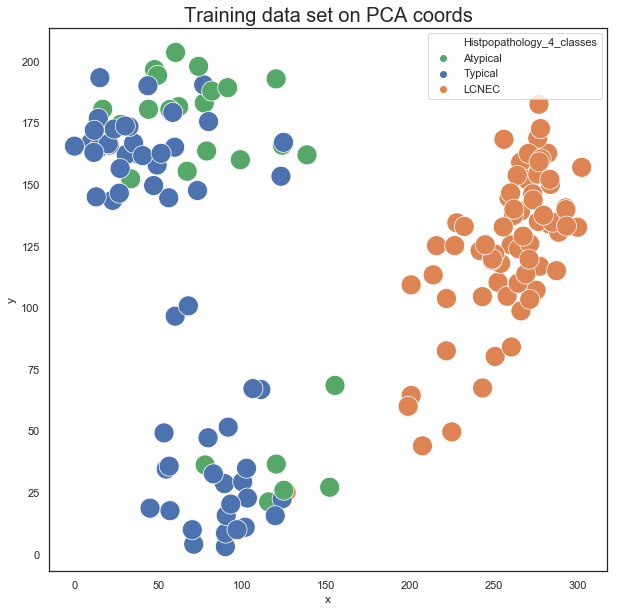

In [219]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2"}
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(coords_mofa_expr_lnen.iloc[:, 1], coords_mofa_expr_lnen.iloc[:, 2],  hue=lv_50_type ,s=400, palette=palette)
plt.title("Training data set on PCA coords",  fontsize=20)
plt.show()

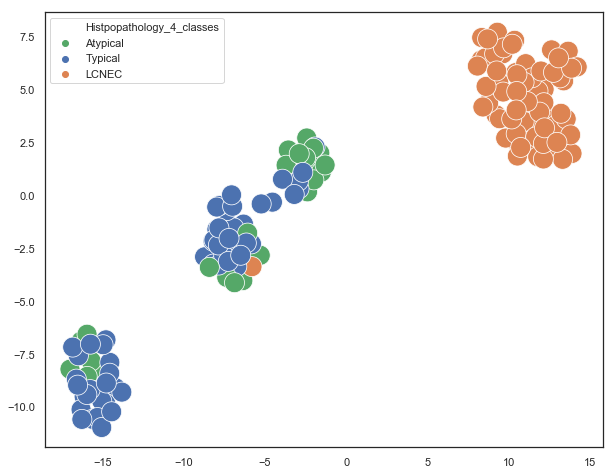

In [220]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2"}
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding = umap.UMAP(min_dist=1).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding[:, 0], y=standard_embedding[:, 1], s=400, hue=lv_50_type, palette=palette)
plt.show()

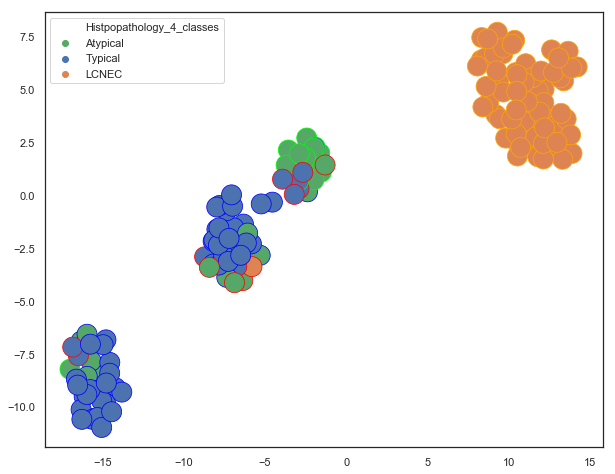

In [221]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", "Unclassified":"C3"}
edges_col = []
for i in ml_pred.iloc[:,1]:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    elif i == 'Unclassified':
        edges_col.append("red")
    else :
        print("warning")


sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=standard_embedding[:, 0], y=standard_embedding[:, 1],  hue=lv_50_type, edgecolor=  edges_col , s=400, palette=palette)
plt.show()

#### Supervised Dimensionality Reduction

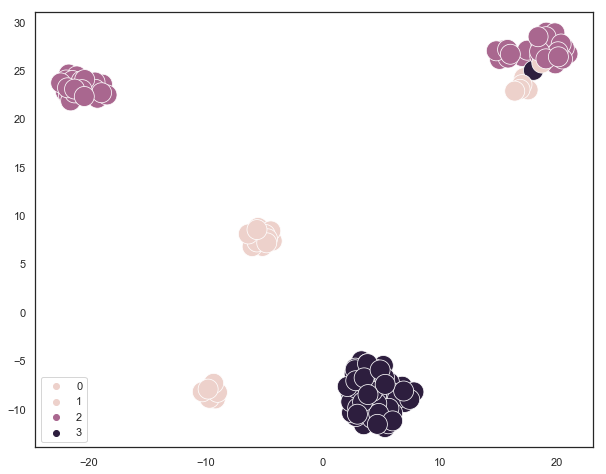

In [222]:
embedding = umap.UMAP(min_dist=1).fit_transform(lv_50_data, y=typeN)

sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=400, hue=typeN)
plt.show()

**Legend complement :**
* 1 Atypical
* 2 Typical
* 3 LCNEC

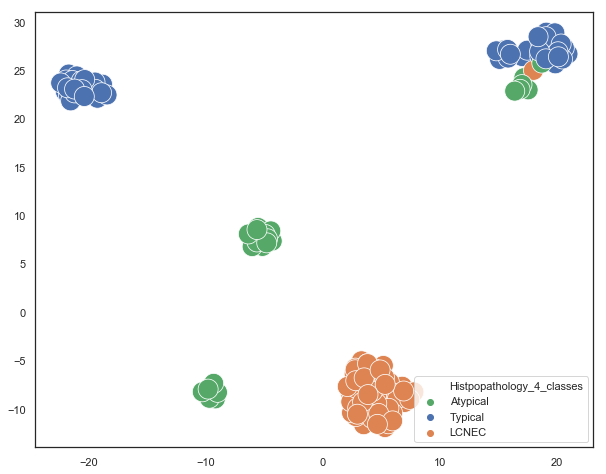

In [223]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", "Unclassified":"C3"}
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],  hue=lv_50_type, s=400, palette=palette)
plt.show()

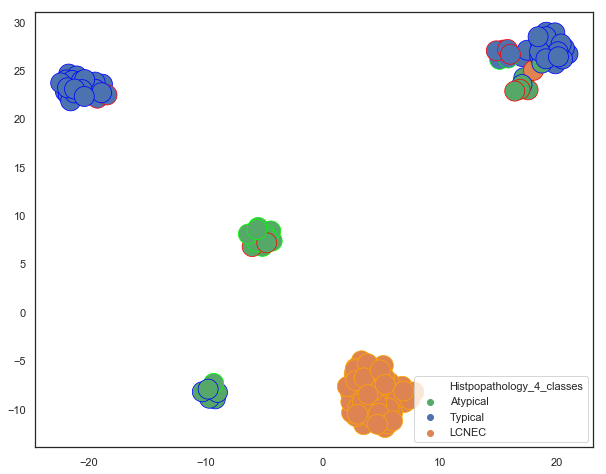

In [224]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", "Unclassified":"C3"}
edges_col = []
for i in ml_pred.iloc[:,1]:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    elif i == 'Unclassified':
        edges_col.append("red")
    else :
        print("warning")


sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],  hue=lv_50_type, edgecolor=  edges_col , s=400, palette=palette)
plt.show()

**Remark : New cluster of typical**
### Local Neighbohood metrics
##### Distance

In [218]:
standard_embedding_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_df['X'] = standard_embedding[:,0]
standard_embedding_df['Y'] = standard_embedding[:,1]
embedding_df = pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_df['X'] = embedding[:,0]
embedding_df['Y'] = embedding[:,1]
d_unsupervised =  Neighborhood.distance_matrix(standard_embedding_df)
d_supervised = Neighborhood.distance_matrix(embedding_df)
Dist_pulmonary =  pd.read_csv("Distance_pulmo.txt", sep="\t") # "real distances" in Rn

In [14]:
d_mofa_expr = Neighborhood.distance_matrix(coords_mofa_expr_lnen)

#### Write Coords

In [15]:
#standard_embedding_df.to_csv(path_or_buf='Unsupervised_Coords.txt', sep='\t')
#embedding_df.to_csv(path_or_buf='Supervised_Coords.txt', sep='\t')

##### CP

In [16]:
#cp1 = Neighborhood.centrality_preservation(d_unsupervised ,  Dist_pulmonary , range(1,len(standard_embedding[:,0]),10),"CP_pulmo_R_unsupervised")
#cp2 = Neighborhood.centrality_preservation(d_supervised ,  Dist_pulmonary , range(1,len(standard_embedding[:,0]),10),"CP_pulmo_R_supervised")

In [17]:
#cp3 = Neighborhood.centrality_preservation(d_mofa_expr , Dist_pulmonary ,  range(1,d_mofa_expr.shape[0],10)  ,"CP_pulmo_R_MOFA")

**Results**

CP2 on projection CP2 unsupervised type :
http://rpubs.com/mathiane/UMAP_R_CP_Supervised
http://rpubs.com/mathiane/UMAP_R_US_CP2
Interprétation difficile

CPN on projection CP2 unsupervised type :
http://rpubs.com/mathiane/UMAP_R_US_CPN
http://rpubs.com/mathiane/UMAP_R_US_CPN_next


CP2 on projection CP2 supervised type :
http://rpubs.com/mathiane/UMAP_R_CP_Supervised
http://rpubs.com/mathiane/UMAP_R_CP_Sup_n
Interprétation difficile


CPN on projection CP2 supervised type :

http://rpubs.com/mathiane/UMAP_S_CPN
http://rpubs.com/mathiane/UMAP_S_CPN_next


**Centralité gobalement plus conservé dans le cas non supervisé**

![CPMeanbyk](cp_supervised_unsupervised.png)

#### Seq and Set

In [18]:
#Neighborhood.main_f(d_unsupervised , Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_unsuper_R" , "seq_diff_pulmo_unsuper_R" , True )
#Neighborhood.main_f(d_supervised, Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_super_R" , "seq_diff_pulmo_super_R" , True )
#Neighborhood.main_f(d_mofa_expr, Dist_pulmonary, d_mofa_expr.shape[0] , "set_diff_pulmo_R_MOFA" , "seq_diff_pulmo_R_MOFA" , True )

![SetDiffbyk](set_supervised_unsupervised_v2.png)
![SeqDiffbyk](seq_diff_by_k.png)

### Clustering

In [19]:
min_dist_to_test = np.arange(0,3, 1.5)
#n_neighbors_to_test = range(2,210)

In [20]:
data_lv_50_type3.head()
data_lv_50_type3.shape

(152, 6400)

##### Stratified cross validation

In [21]:
CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )
X_train = CV[0]
X_test = CV[1]
y_train = CV[2]
y_test = CV[3]

In [22]:
y_test = list(y_test)
print('len y test', len(y_test))
print(y_test.count('LCNEC') , y_test.count('Typical') , y_test.count('Atypical'))
y_test.count('LCNEC')/len(y_test) , y_test.count('Typical')/len(y_test) , y_test.count('Atypical')/len(y_test)

len y test 38
17 13 8


(0.4473684210526316, 0.34210526315789475, 0.21052631578947367)

In [23]:
y_train = list(y_train)
y_train.count('LCNEC')/len(y_train) , y_train.count('Typical')/len(y_train) , y_train.count('Atypical')/len(y_train)

(0.45614035087719296, 0.39473684210526316, 0.14912280701754385)

In [24]:
lv_50_type = list(lv_50_type)
lv_50_type.count('LCNEC')/len(lv_50_type) , lv_50_type.count('Typical')/len(lv_50_type) , lv_50_type.count('Atypical')/len(lv_50_type)

(0.45394736842105265, 0.3815789473684211, 0.16447368421052633)

##### Without UMAP Preprocessing

In [25]:
knn_1 = KNeighborsClassifier().fit(X_train, y_train)
svc_1 = SVC().fit(X_train, y_train)
kmeans_1 = KMeans(n_clusters=3).fit(X_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [26]:
knn_1.fit(X_train, y_train)
pred_knn_1 = knn_1.predict(X_test)
pred_kmeans_1 = kmeans_1.predict(X_test)
kmean_acc_1 , kmean_lab_1 =label_pred(y_test, pred_kmeans_1 )
print("Knn accurancy  : ",knn_1.score(X_test, y_test))
print("SVC accurancy  : ",svc_1.score(X_test, y_test))
print("Kmeans accurancy  : ", kmean_acc_1)

pred_label  0   1  2
y_test              
Atypical    8   0  0
LCNEC       0  16  1
Typical     8   0  5
acc_score [0.7631578947368421, 0.23684210526315788, 0.13157894736842105, 0.23684210526315788, 0.0, 0.631578947368421]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.6842105263157895
Kmeans accurancy  :  0.7631578947368421


## According PCA coords

In [27]:
coords_mofa_expr_lnen
coords_mofa_expr_lnen_v2 = coords_mofa_expr_lnen.iloc[:,1:3]
coords_mofa_expr_lnen_m = coords_mofa_expr_lnen_v2.as_matrix()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
coords_mofa_expr_lnen_v2.head()

,x,y
0,62.113357,181.583051
1,16.872215,180.526922
2,27.587890,174.407738
3,78.781709,163.594944
4,47.787185,196.630058


In [29]:
knn_acc_pca =[]
svc_acc_pca =[]
kmeans_acc_pca =[]
otp_spatial_cor =[]
angptl3_spatial_cor=[]
dendritic_cells_spatial_cor= []
for j  in range(10):
    CV = train_test_split(coords_mofa_expr_lnen_v2,lv_50_type,lv_50_type )
    X_train = CV[0]
    X_test = CV[1]
    y_train = CV[2]
    y_test = CV[3]
        

    knn_pca = KNeighborsClassifier().fit(X_train, y_train)
    svc_pca = SVC().fit(X_train, y_train)
    kmeans_pca = KMeans(n_clusters=3).fit(X_train)
    knn_pca.fit(X_train, y_train)
    pred_knn_pca = knn_pca.predict(X_test)
    pred_kmeans_pca = kmeans_pca.predict(X_test)
    kmean_acc_pca , kmean_lab_pca =label_pred(y_test, pred_kmeans_pca )
    
    
    print("Knn accurancy  : ",knn_pca.score(X_test, y_test))
    print("SVC accurancy  : ",svc_pca.score(X_test, y_test))
    print("Kmeans accurancy  : ", kmean_acc_pca)
    knn_acc_pca.append(knn_pca.score(X_test, y_test))  
    svc_acc_pca.append(svc_pca.score(X_test, y_test))
    kmeans_acc_pca.append(kmean_acc_pca)
        

    wknn10 = pysal.knnW(X_test, k = 10)
    
    OTP_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
    ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
    dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])

    mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
    otp_spatial_cor.append(mi_otp.I)


    mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
    angptl3_spatial_cor.append(mi_angptl3.I)
 

    mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
    dendritic_cells_spatial_cor.append(mi_dendritic_cell.I)
  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  0  7
LCNEC       19  0  0
Typical      0  8  4
acc_score [0.10526315789473684, 0.21052631578947367, 0.6052631578947368, 0.0, 0.8947368421052632, 0.18421052631578946]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.5263157894736842
Kmeans accurancy  :  0.8947368421052632


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    3   0  1
LCNEC       0  23  0
Typical     4   0  7
acc_score [0.868421052631579, 0.07894736842105263, 0.18421052631578946, 0.10526315789473684, 0.02631578947368421, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.9473684210526315
SVC accurancy  :  0.42105263157894735
Kmeans accurancy  :  0.868421052631579


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   5  0
LCNEC       13   0  0
Typical      0  11  9
acc_score [0.23684210526315788, 0.2894736842105263, 0.7105263157894737, 0.13157894736842105, 0.631578947368421, 0.0]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.3684210526315789
Kmeans accurancy  :  0.7105263157894737


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  1
LCNEC       0  21  0
Typical     6   0  6
acc_score [0.8157894736842105, 0.10526315789473684, 0.15789473684210525, 0.15789473684210525, 0.02631578947368421, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.5526315789473685
Kmeans accurancy  :  0.8157894736842105


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   0  2
LCNEC       0  17  1
Typical     9   0  7
acc_score [0.6842105263157895, 0.07894736842105263, 0.18421052631578946, 0.2631578947368421, 0.05263157894736842, 0.7368421052631579]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.5
Kmeans accurancy  :  0.7368421052631579


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    3   0  2
LCNEC       0  18  0
Typical     7   0  8
acc_score [0.7631578947368421, 0.07894736842105263, 0.21052631578947367, 0.18421052631578946, 0.05263157894736842, 0.7105263157894737]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.9473684210526315
SVC accurancy  :  0.47368421052631576
Kmeans accurancy  :  0.7631578947368421


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  4  1
LCNEC       19  0  0
Typical      0  8  6
acc_score [0.15789473684210525, 0.21052631578947367, 0.7631578947368421, 0.10526315789473684, 0.7368421052631579, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.5
Kmeans accurancy  :  0.7631578947368421


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  3
LCNEC       0  14  0
Typical     9   0  8
acc_score [0.6842105263157895, 0.10526315789473684, 0.21052631578947367, 0.23684210526315788, 0.07894736842105263, 0.6842105263157895]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.3684210526315789
Kmeans accurancy  :  0.6842105263157895


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  2  4
LCNEC       20  0  0
Typical      0  3  9
acc_score [0.23684210526315788, 0.07894736842105263, 0.8157894736842105, 0.05263157894736842, 0.7105263157894737, 0.10526315789473684]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.5789473684210527
Kmeans accurancy  :  0.8157894736842105


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     4   0  1
LCNEC        0  14  1
Typical     10   0  8
acc_score [0.6842105263157895, 0.13157894736842105, 0.21052631578947367, 0.2894736842105263, 0.02631578947368421, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.42105263157894735
Kmeans accurancy  :  0.6842105263157895


In [30]:
list_clustering=["knn_acc"]*10 + ["svc_acc"]*10 + ["kmeans_acc"]*10
Acc_val = knn_acc_pca + svc_acc_pca + kmeans_acc_pca
clustering_res_pca = pd.DataFrame() 
clustering_res_pca['clustering_method'] = list_clustering
clustering_res_pca['Acc_val'] = Acc_val
clustering_res_pca.shape

(30, 2)

In [31]:
list_spatial_cor = ["otp"]*10 + ["angptl3"]*10 + ["dendritic_cell"]*10
spatial_cor_val = otp_spatial_cor + angptl3_spatial_cor + dendritic_cells_spatial_cor
spatial_cor = pd.DataFrame() 
spatial_cor ['list_spatial_cor'] = list_spatial_cor
spatial_cor ['spatial_cor_val'] = spatial_cor_val
spatial_cor.shape

(30, 2)

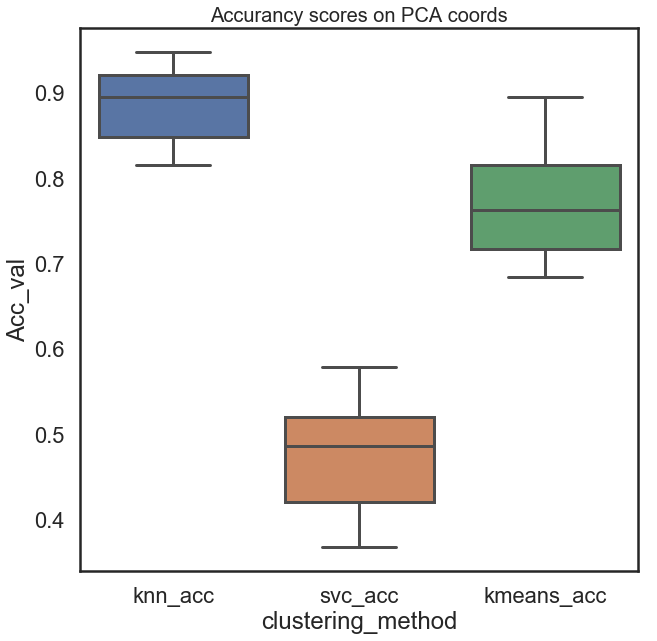

In [32]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res_pca)

plt.title("Accurancy scores on PCA coords",  fontsize=20)
plt.show()

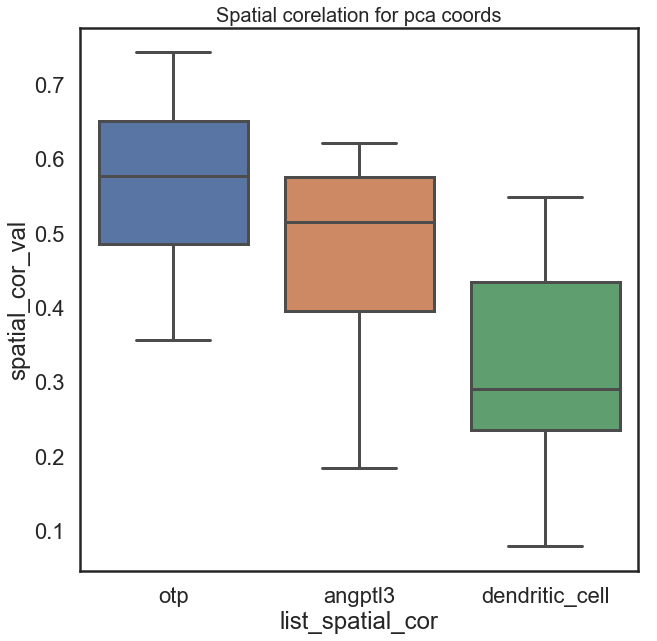

In [33]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="list_spatial_cor", y="spatial_cor_val", data=spatial_cor)
plt.title("Spatial corelation for pca coords",  fontsize=20)
plt.show()

#### PCA clustering prediction (graph)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    1   0   3
LCNEC       1  16   0
Typical     6   0  11
acc_score [0.7368421052631579, 0.02631578947368421, 0.3157894736842105, 0.15789473684210525, 0.10526315789473684, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.4473684210526316
Kmeans accurancy  :  0.7368421052631579


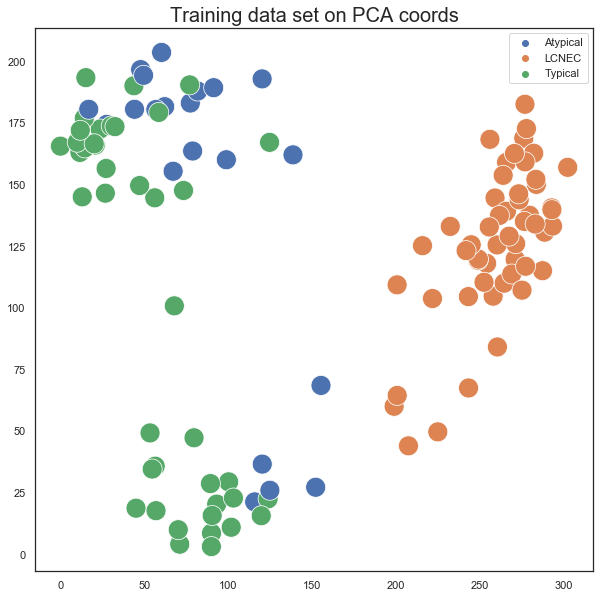

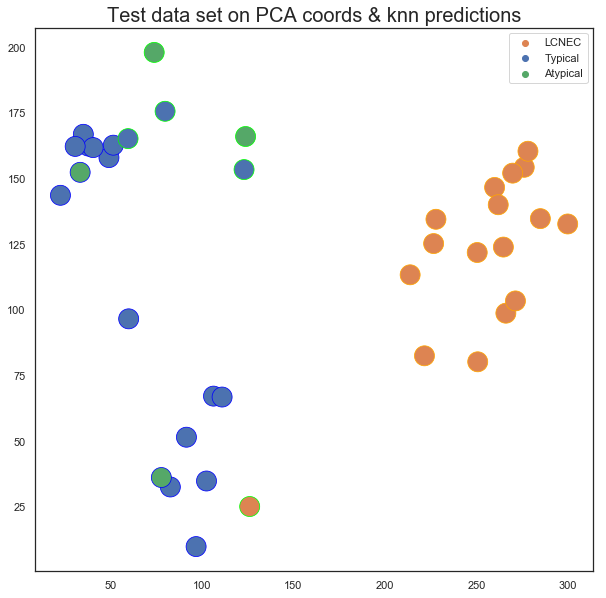

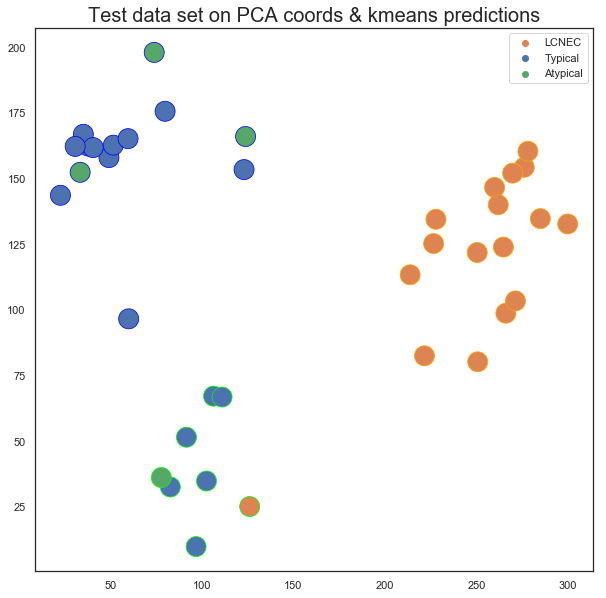

In [34]:
CV = train_test_split(coords_mofa_expr_lnen_m,lv_50_type,lv_50_type ) # Apprentissage à partir des coordonénes de la PCA
X_train = CV[0]
X_test = CV[1]
y_train = CV[2]
y_test = CV[3]


knn_pca = KNeighborsClassifier().fit(X_train, y_train)
svc_pca = SVC().fit(X_train, y_train)
kmeans_pca = KMeans(n_clusters=3).fit(X_train)


knn_pca.fit(X_train, y_train)
pred_knn_pca = knn_pca.predict(X_test)
pred_kmeans_pca = kmeans_pca.predict(X_test)
kmean_acc_pca , kmean_lab_pca =label_pred(y_test, pred_kmeans_pca)
print("Knn accurancy  : ",knn_pca.score(X_test, y_test))
print("SVC accurancy  : ",svc_pca.score(X_test, y_test))
print("Kmeans accurancy  : ", kmean_acc_pca)

edges_col = []
for i in pred_knn_pca:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    else :
        print("warning")

        
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(X_train[:, 0], X_train[:, 1],  hue=y_train ,s=400)
plt.title("Training data set on PCA coords",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(X_test[:, 0], X_test[:, 1],  hue=y_test, edgecolor=  edges_col ,s=400, palette =palette)
plt.title("Test data set on PCA coords & knn predictions",  fontsize=20)
plt.show()


edges_col = []
for i in kmean_lab_pca:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    else :
        print("warning")

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(X_test[:, 0], X_test[:, 1],  hue=y_test, edgecolor=  edges_col ,s=400, palette =palette)
plt.title("Test data set on PCA coords & kmeans predictions",  fontsize=20)
plt.show()

#### PCA Autocorrélation spatiale

In [35]:
print(pysal.knnW(coords_mofa_expr_lnen_m, k = 7))
wknn7 = pysal.knnW(coords_mofa_expr_lnen_m, k = 7)

#print(type(spatial_attributes.iloc[:,1]))

OTP_gene_expression = np.array(spatial_attributes.iloc[:,0])
ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[:,1])
dendritic_cell = np.array(spatial_attributes.iloc[:,2])

mi_otp = pysal.Moran(OTP_gene_expression, wknn7 , two_tailed=True)
print(mi_otp.I)

mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn7 , two_tailed=True)
print(mi_angptl3.I)

mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn7 , two_tailed=True)
print(mi_dendritic_cell.I)
#help(pysal)

0.7800240154201463
0.712750020561931
0.47735588487037767



These scores presents classifiers' accury (TP/(TP+FP)).
##### Unsupervised UMAP Preprocessing

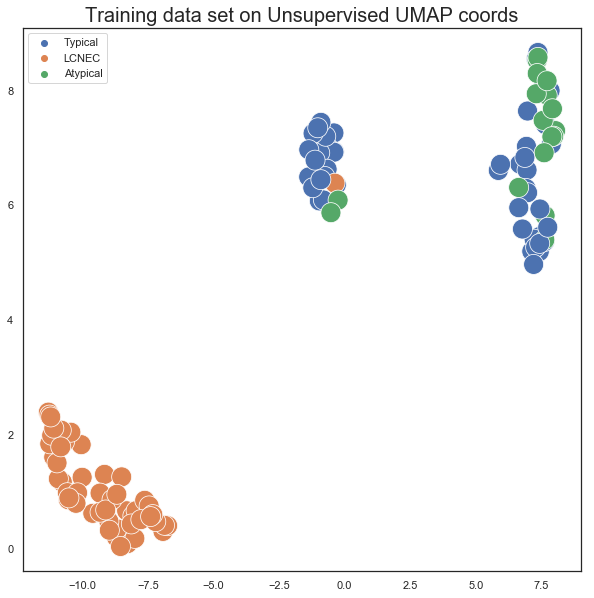

In [36]:
CV = train_test_split(coords_mofa_expr_lnen_m,lv_50_type,lv_50_type ) # Apprentissage à partir des coordonénes de la PCA
X_train = CV[0]
X_test = CV[1]
y_train = CV[2]
y_test = CV[3]

palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2"}
trans = umap.UMAP().fit(X_train)
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=trans.embedding_[:, 0], y=trans.embedding_[:, 1],  hue=y_train, palette =palette ,s=400)
plt.title("Training data set on Unsupervised UMAP coords",  fontsize=20)
plt.show()

In [37]:
svc_2 = SVC().fit(trans.embedding_, y_train)
knn_2 = KNeighborsClassifier().fit(trans.embedding_, y_train)
kmeans_2 = KMeans(n_clusters=3).fit(trans.embedding_, y_train)
test_embedding = trans.transform(X_test)
svc_pred_2= svc_2.predict(test_embedding)
knn_pred_2 = knn_2.predict(test_embedding)
kmeans_pred_2 = kmeans_2.predict(test_embedding)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


**Graph for KNN prediction**

In [38]:
edges_col = []
for i in knn_pred_2:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    else :
        print("warning")

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_embedding[:, 0], test_embedding[:, 1],  hue=y_test, edgecolor=  edges_col ,s=400, palette =palette)
plt.title("Test data set on Unsupervised UMAP coords & knn predictions",  fontsize=20)
plt.show()


**Graph for Kmeans prediction**

In [40]:
kmean_acc_2 , kmean_lab_2 =label_pred(y_test, kmeans_pred_2 )

pred_label  0   1  2
y_test              
Atypical    4   0  4
LCNEC       0  19  0
Typical     4   0  7
acc_score [0.7894736842105263, 0.10526315789473684, 0.18421052631578946, 0.10526315789473684, 0.10526315789473684, 0.7105263157894737]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}


In [41]:
edges_col = []
for i in kmean_lab_2:
    if i == "Typical":
        edges_col.append("blue")
    elif i == "LCNEC":
        edges_col.append("orange")
    elif i == "Atypical":
        edges_col.append("lime")
    else :
        print("warning")

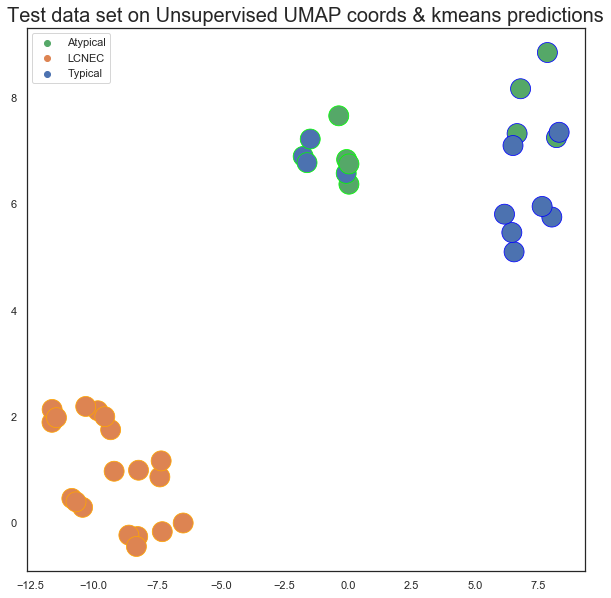

In [42]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_embedding[:, 0], test_embedding[:, 1],  hue=y_test, edgecolor=  edges_col ,s=400, palette =palette)
plt.title("Test data set on Unsupervised UMAP coords & kmeans predictions",  fontsize=20)
plt.show()

In [43]:
print("Knn accurancy  : ",knn_2.score(trans.transform(X_test), y_test) )
print("SVC accurancy  : ",svc_2.score(trans.transform(X_test), y_test) )
print("Kmeans accurancy  : ",kmean_acc_2 )

Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.7894736842105263


In [44]:
print("Knn silhouette score  : ",silhouette_score(trans.transform(X_test), knn_pred_2) )
print("Svc silhouette score  : ",silhouette_score(trans.transform(X_test), svc_pred_2) )
print("Kmeans silhouette score  : ",silhouette_score(trans.transform(X_test), kmeans_pred_2) )

Knn silhouette score  :  0.50064874
Svc silhouette score  :  0.47100443
Kmeans silhouette score  :  0.79086787


### UMAP Unsupervised mean accuracy

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   5  1
LCNEC       13   0  0
Typical      0  11  8
acc_score [0.21052631578947367, 0.2894736842105263, 0.6842105263157895, 0.13157894736842105, 0.6578947368421053, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.6842105263157895


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  0  5
LCNEC       17  0  0
Typical      0  8  8
acc_score [0.21052631578947367, 0.21052631578947367, 0.6578947368421053, 0.0, 0.7894736842105263, 0.13157894736842105]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7894736842105263


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    8   0  1
LCNEC       0  14  0
Typical     7   0  8
acc_score [0.7894736842105263, 0.21052631578947367, 0.21052631578947367, 0.18421052631578946, 0.02631578947368421, 0.5789473684210527]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.7894736842105263


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  5  2
LCNEC       22  0  0
Typical      0  6  3
acc_score [0.07894736842105263, 0.15789473684210525, 0.7894736842105263, 0.13157894736842105, 0.7894736842105263, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7894736842105263


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  4  1
LCNEC       16  0  0
Typical      0  8  9
acc_score [0.23684210526315788, 0.21052631578947367, 0.7631578947368421, 0.10526315789473684, 0.6578947368421053, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.9473684210526315
SVC accurancy  :  0.9736842105263158
Kmeans accurancy  :  0.7631578947368421


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  6  2
LCNEC       18  1  0
Typical      0  4  7
acc_score [0.21052631578947367, 0.10526315789473684, 0.8157894736842105, 0.15789473684210525, 0.631578947368421, 0.07894736842105263]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.8157894736842105


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  7  3
LCNEC       16  1  0
Typical      0  8  3
acc_score [0.10526315789473684, 0.21052631578947367, 0.6842105263157895, 0.18421052631578946, 0.7105263157894737, 0.10526315789473684]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.7105263157894737


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0  1   2
y_test              
Atypical    3  2   0
LCNEC       0  0  19
Typical     7  7   0
acc_score [0.07894736842105263, 0.7631578947368421, 0.05263157894736842, 0.7368421052631579, 0.18421052631578946, 0.18421052631578946]
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7631578947368421


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    0   0  7
LCNEC       0  16  0
Typical     8   0  7
acc_score [0.6052631578947368, 0.0, 0.18421052631578946, 0.21052631578947367, 0.18421052631578946, 0.8157894736842105]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.9473684210526315
Kmeans accurancy  :  0.8157894736842105


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  3  2
LCNEC       19  0  0
Typical      0  8  6
acc_score [0.15789473684210525, 0.21052631578947367, 0.7368421052631579, 0.07894736842105263, 0.7631578947368421, 0.05263157894736842]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7631578947368421


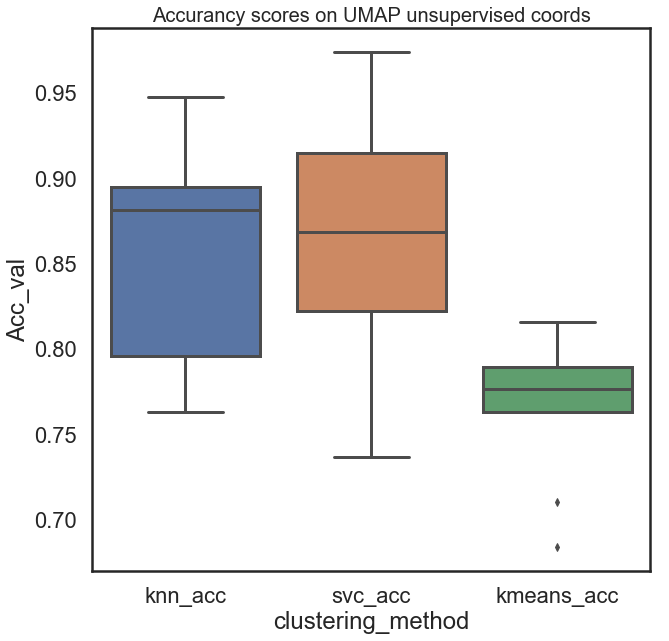

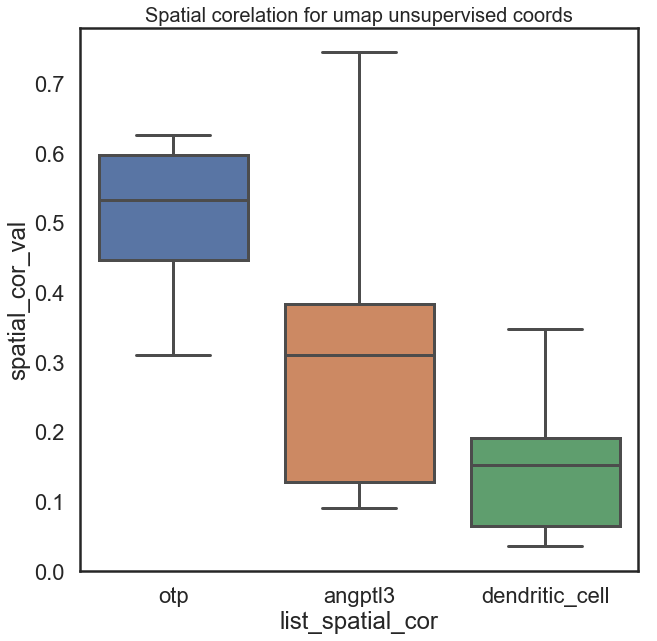

In [45]:
knn_acc_umap_us =[]
svc_acc_umap_us =[]
kmeans_acc_umap_us =[]
otp_spatial_cor_umap_us =[]
angptl3_spatial_cor_umap_us =[]
dendritic_cells_spatial_cor_umap_us = []
for j  in range(10):
   
    CV = train_test_split(lv_50_data,lv_50_type,lv_50_type)
    
    X_train = CV[0]
    X_test = CV[1]
    y_train = CV[2]
    y_test = CV[3]
    trans = umap.UMAP().fit(X_train) 
   
    knn_umap_us = KNeighborsClassifier().fit(trans.embedding_, y_train)
    svc_umap_us = SVC().fit(trans.embedding_, y_train)
    kmeans_umap_us = KMeans(n_clusters=3).fit(trans.embedding_)
    
    test_embedding = trans.transform(X_test)
    svc_pred_umap_us= svc_umap_us.predict(test_embedding)
    knn_pred_umap_us = knn_umap_us.predict(test_embedding)
    kmeans_pred_umap_us = kmeans_umap_us.predict(test_embedding)
    
    kmean_acc_umap_us , kmean_lab_umap_us =label_pred(y_test, kmeans_pred_umap_us)
      
    print("Knn accurancy  : ",knn_umap_us.score(test_embedding, y_test))
    print("SVC accurancy  : ",svc_umap_us.score(test_embedding, y_test))
    print("Kmeans accurancy  : ", kmean_acc_umap_us)
    knn_acc_umap_us.append(knn_umap_us.score(test_embedding, y_test))  
    svc_acc_umap_us.append(svc_umap_us.score(test_embedding, y_test))
    kmeans_acc_umap_us.append(kmean_acc_umap_us)
    
    #print('X_train.index', type(X_train.index))

    wknn10 = pysal.knnW(test_embedding, k = 10)
    
    OTP_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
    ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
    dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])
    
    mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
    otp_spatial_cor_umap_us.append(mi_otp.I)


    mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
    angptl3_spatial_cor_umap_us.append(mi_angptl3.I)
 

    mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
    dendritic_cells_spatial_cor_umap_us.append(mi_dendritic_cell.I)


list_clustering=["knn_acc"]*10 + ["svc_acc"]*10 + ["kmeans_acc"]*10
Acc_val = knn_acc_umap_us +svc_acc_umap_us + kmeans_acc_umap_us

clustering_res_umap_us = pd.DataFrame() 
clustering_res_umap_us['clustering_method'] = list_clustering
clustering_res_umap_us['Acc_val'] = Acc_val
clustering_res_umap_us.shape


list_spatial_cor_umap_us = ["otp"]*10 + ["angptl3"]*10 + ["dendritic_cell"]*10
spatial_cor_val_umap_us = otp_spatial_cor_umap_us + angptl3_spatial_cor_umap_us + dendritic_cells_spatial_cor_umap_us
spatial_cor_umap_us = pd.DataFrame() 
spatial_cor_umap_us ['list_spatial_cor'] = list_spatial_cor_umap_us
spatial_cor_umap_us ['spatial_cor_val'] = spatial_cor_val_umap_us
spatial_cor_umap_us.shape

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res_umap_us)
plt.title("Accurancy scores on UMAP unsupervised coords",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="list_spatial_cor", y="spatial_cor_val", data=spatial_cor_umap_us)
plt.title("Spatial corelation for umap unsupervised coords",  fontsize=20)
plt.show()


##### Supervised UMAP Preprocessing

In [46]:
CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )

X_train = CV[0]
X_test = CV[1]
y_train = CV[2]
y_test = CV[3]



In [47]:
y_train = list(y_train)
y_trainN  = []
for i in range(len(y_train)):
    if y_train[i]== 'Atypical':
        y_trainN.append(1)
    elif y_train[i]== 'Typical':
        y_trainN.append(2)
    elif y_train[i]== 'LCNEC':
        y_trainN.append(3)
    else :
        print("WARNING i = ", i)
        break

trans_sup = umap.UMAP().fit(X_train, y=y_trainN)

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=trans_sup.embedding_[:, 0], y=trans_sup.embedding_[:, 1],  hue=y_train ,s=400)
plt.title("Training data set on UMAP supervised coords",  fontsize=20)
plt.show()

In [117]:
########################################@@####### A FINIR
lv_50_type_df = pd.DataFrame(lv_50_type) 
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(lv_50_data, lv_50_type_df):
       #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = lv_50_data.iloc[train_index,:], lv_50_data.iloc[test_index,:]
        y_train, y_test = lv_50_type_df.iloc[train_index,:], lv_50_type_df.iloc[test_index,:]
        


TRAIN: [  5   6   7   8   9  10  11  12  13  14  15  16  39  40  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  65  67  68  69  70  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151] TEST: [ 0  1  2  3  4 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 63 64 66 71]
TRAIN: [  0   1   2   3   4  10  11  12  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  49  50
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  77  78  80  82  83  85  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 12

In [116]:
type(lv_50_data)
type(lv_50_type)

list

In [49]:
svc_3 = SVC().fit(trans_sup.embedding_, y_train)
knn_3 = KNeighborsClassifier().fit(trans_sup.embedding_, y_train)
kmeans_3 = KMeans(n_clusters=3).fit(trans_sup.embedding_, y_train)
test_sup_embedding = trans_sup.transform(X_test)
svc_pred_3 = svc_3.predict(test_sup_embedding)
knn_pred_3 = knn_3.predict(test_sup_embedding)
kmeans_pred_3 = kmeans_3.predict(test_sup_embedding)
kmean_acc_umap_s , kmean_lab_umap_s =label_pred(y_test, kmeans_pred_3)

pred_label   0   1  2
y_test               
Atypical     3   0  3
LCNEC        0  20  0
Typical     11   0  1
acc_score [0.631578947368421, 0.07894736842105263, 0.02631578947368421, 0.2894736842105263, 0.07894736842105263, 0.8947368421052632]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [50]:
edges_col_2 = []
for i in knn_pred_3:
    if i == "Typical":
        edges_col_2.append("orange")
    elif i == "LCNEC":
        edges_col_2.append("blue")
    elif i == "Atypical":
        edges_col_2.append("lime")
    else :
        print("warning")

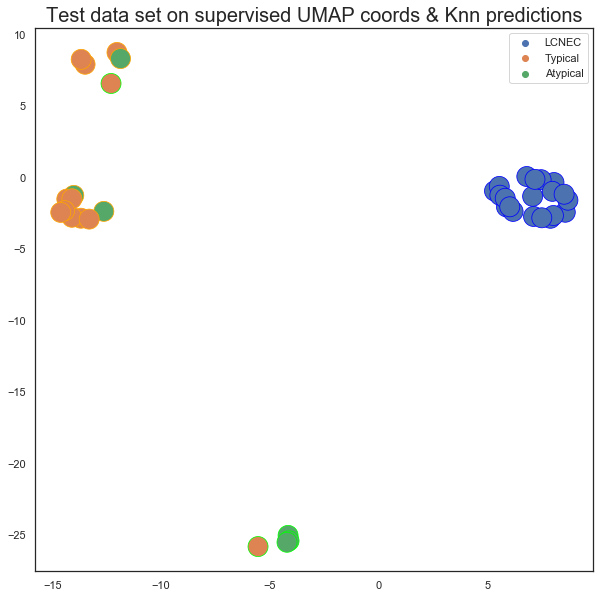

In [51]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_sup_embedding[:, 0], test_sup_embedding[:, 1],  hue=y_test, edgecolor=edges_col_2 ,s=400)
plt.title("Test data set on supervised UMAP coords & Knn predictions",  fontsize=20)
plt.show()

In [52]:
kmean_acc_umap_s , kmean_lab_umap_s =label_pred(y_test, kmeans_pred_3)

pred_label   0   1  2
y_test               
Atypical     3   0  3
LCNEC        0  20  0
Typical     11   0  1
acc_score [0.631578947368421, 0.07894736842105263, 0.02631578947368421, 0.2894736842105263, 0.07894736842105263, 0.8947368421052632]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}


In [53]:
edges_col_3 = []
for i in kmean_lab_umap_s:
    if i == "Typical":
        edges_col_3.append("lime")
    elif i == "LCNEC":
        edges_col_3.append("blue")
    elif i == "Atypical":
        edges_col_3.append("orange")
    else :
        print("warning")

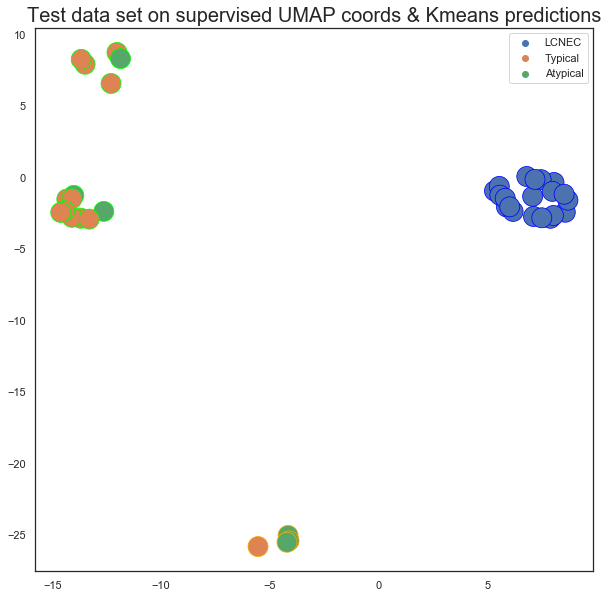

In [54]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(test_sup_embedding[:, 0], test_sup_embedding[:, 1],  hue=y_test, edgecolor=edges_col_3 ,s=400)
plt.title("Test data set on supervised UMAP coords & Kmeans predictions",  fontsize=20)
plt.show()

In [55]:
print("Knn accurancy  : ",knn_3.score(trans_sup.transform(X_test), y_test) )
print("SVC accurancy  : ",svc_3.score(trans_sup.transform(X_test), y_test) )
print("Kmeans accurancy  : ", kmean_acc_umap_s)

Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.8947368421052632


In [56]:
print("Knn silhouette score  : ",silhouette_score(trans_sup.transform(X_test), knn_pred_3) )
print("Svc silhouette score  : ",silhouette_score(trans_sup.transform(X_test), svc_pred_3) )
print("Kmeans silhouette score  : ",silhouette_score(trans_sup.transform(X_test), kmeans_pred_3) )

Knn silhouette score  :  0.78246987
Svc silhouette score  :  0.8510441
Kmeans silhouette score  :  0.8510441


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    3   0  2
LCNEC       0  16  0
Typical     8   0  9
acc_score [0.7368421052631579, 0.07894736842105263, 0.23684210526315788, 0.21052631578947367, 0.05263157894736842, 0.6842105263157895]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7368421052631579


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   2  3
LCNEC       0  18  1
Typical     5   3  4
acc_score [0.631578947368421, 0.15789473684210525, 0.15789473684210525, 0.21052631578947367, 0.15789473684210525, 0.6842105263157895]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7631578947368421
Kmeans accurancy  :  0.6842105263157895


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   3  3
LCNEC       18   0  0
Typical      0  12  2
acc_score [0.05263157894736842, 0.3157894736842105, 0.6052631578947368, 0.07894736842105263, 0.868421052631579, 0.07894736842105263]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.868421052631579


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     3  3  3
LCNEC       16  0  0
Typical      6  2  5
acc_score [0.21052631578947367, 0.13157894736842105, 0.631578947368421, 0.23684210526315788, 0.5526315789473685, 0.23684210526315788]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.631578947368421


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    1   0   6
LCNEC       0  16   0
Typical     5   0  10
acc_score [0.7105263157894737, 0.02631578947368421, 0.2631578947368421, 0.13157894736842105, 0.15789473684210525, 0.7105263157894737]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7105263157894737


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  2  3
LCNEC       23  0  1
Typical      0  1  8
acc_score [0.21052631578947367, 0.05263157894736842, 0.868421052631579, 0.07894736842105263, 0.7105263157894737, 0.07894736842105263]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.868421052631579


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  6  2
LCNEC       16  0  0
Typical      0  9  5
acc_score [0.13157894736842105, 0.23684210526315788, 0.7105263157894737, 0.15789473684210525, 0.7105263157894737, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7105263157894737


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     1  2  3
LCNEC       14  0  0
Typical      4  9  5
acc_score [0.15789473684210525, 0.2631578947368421, 0.5526315789473685, 0.15789473684210525, 0.6842105263157895, 0.18421052631578946]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.7368421052631579
SVC accurancy  :  0.7631578947368421
Kmeans accurancy  :  0.6842105263157895


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   4  3
LCNEC       20   0  0
Typical      0  10  1
acc_score [0.02631578947368421, 0.2631578947368421, 0.6578947368421053, 0.10526315789473684, 0.868421052631579, 0.07894736842105263]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.868421052631579


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     6  2  1
LCNEC       15  0  0
Typical      1  7  6
acc_score [0.3157894736842105, 0.34210526315789475, 0.6052631578947368, 0.07894736842105263, 0.6052631578947368, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.6052631578947368


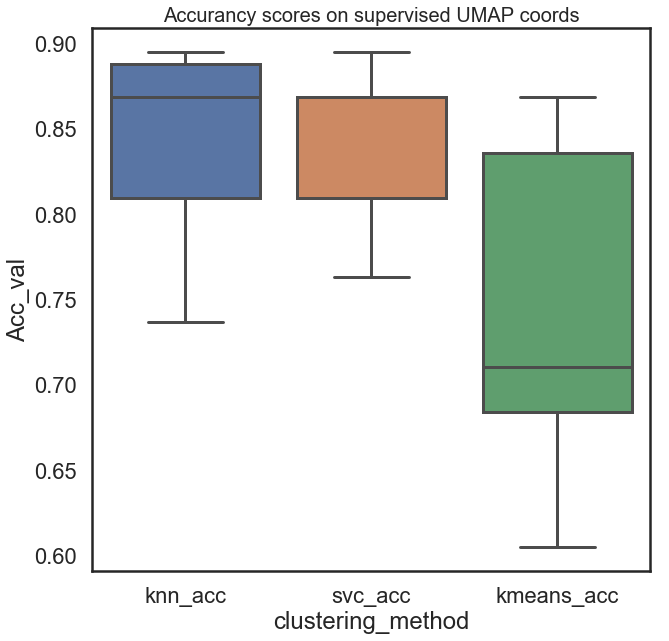

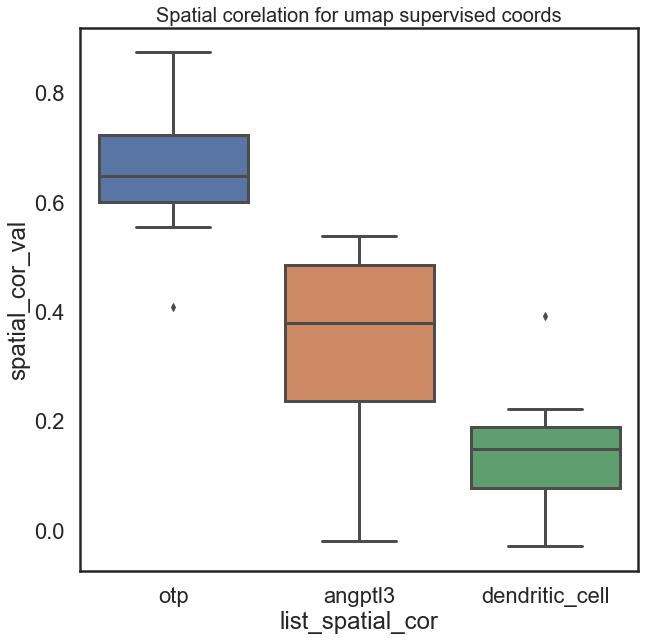

In [57]:
knn_acc_umap_s =[]
svc_acc_umap_s =[]
kmeans_acc_umap_s =[]
otp_spatial_cor_umap_s =[]
angptl3_spatial_cor_umap_s =[]
dendritic_cells_spatial_cor_umap_s = []
for j  in range(10):
   
    CV = train_test_split(lv_50_data,lv_50_type,lv_50_type)
    X_train = CV[0]
    X_test = CV[1]
    y_train = CV[2]
    y_test = CV[3]
    
    y_train = list(y_train)
    y_trainN  = []
    for i in range(len(y_train)):
        if y_train[i]== 'Atypical':
            y_trainN.append(1)
        elif y_train[i]== 'Typical':
            y_trainN.append(2)
        elif y_train[i]== 'LCNEC':
            y_trainN.append(3)
        else :
            print("WARNING i = ", i)

    trans = umap.UMAP().fit(X_train, y=y_trainN)
    
    knn_umap_s = KNeighborsClassifier().fit(trans.embedding_, y_train)
    svc_umap_s = SVC().fit(trans.embedding_, y_train)
    kmeans_umap_s = KMeans(n_clusters=3).fit(trans.embedding_)
    
    test_embedding = trans.transform(X_test)
    svc_pred_umap_s= svc_umap_s.predict(test_embedding)
    knn_pred_umap_s = knn_umap_s.predict(test_embedding)
    kmeans_pred_umap_s = kmeans_umap_s.predict(test_embedding)
    
    kmean_acc_umap_s , kmean_lab_umap_s =label_pred(y_test, kmeans_pred_umap_s)
      
    print("Knn accurancy  : ",knn_umap_s.score(test_embedding, y_test))
    print("SVC accurancy  : ",svc_umap_s.score(test_embedding, y_test))
    print("Kmeans accurancy  : ", kmean_acc_umap_s)
    knn_acc_umap_s.append(knn_umap_s.score(test_embedding, y_test))  
    svc_acc_umap_s.append(svc_umap_s.score(test_embedding, y_test))
    kmeans_acc_umap_s.append(kmean_acc_umap_s)

    
    wknn10 = pysal.knnW(test_embedding, k = 10)
    
    OTP_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
    ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
    dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])
    
    mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
    otp_spatial_cor_umap_s.append(mi_otp.I)


    mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
    angptl3_spatial_cor_umap_s.append(mi_angptl3.I)
 

    mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
    dendritic_cells_spatial_cor_umap_s.append(mi_dendritic_cell.I)



list_clustering=["knn_acc"]*10 + ["svc_acc"]*10 + ["kmeans_acc"]*10
Acc_val = knn_acc_umap_s + svc_acc_umap_s + kmeans_acc_umap_s

clustering_res_umap_s = pd.DataFrame() 
clustering_res_umap_s['clustering_method'] = list_clustering
clustering_res_umap_s['Acc_val'] = Acc_val
clustering_res_umap_s.shape


list_spatial_cor_umap_s = ["otp"]*10 + ["angptl3"]*10 + ["dendritic_cell"]*10
spatial_cor_val_umap_s = otp_spatial_cor_umap_s + angptl3_spatial_cor_umap_s + dendritic_cells_spatial_cor_umap_s
spatial_cor_umap_s = pd.DataFrame() 
spatial_cor_umap_s ['list_spatial_cor'] = list_spatial_cor_umap_s
spatial_cor_umap_s ['spatial_cor_val'] = spatial_cor_val_umap_s
spatial_cor_umap_s.shape

sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res_umap_s)
plt.title("Accurancy scores on supervised UMAP coords",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="list_spatial_cor", y="spatial_cor_val", data=spatial_cor_umap_s)
plt.title("Spatial corelation for umap supervised coords",  fontsize=20)
plt.show()



# Min dist

In [58]:
min_dist_test = [0,0.5,1]

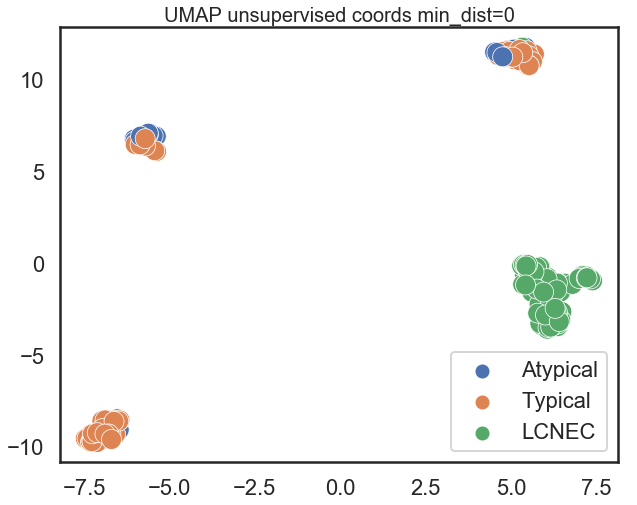

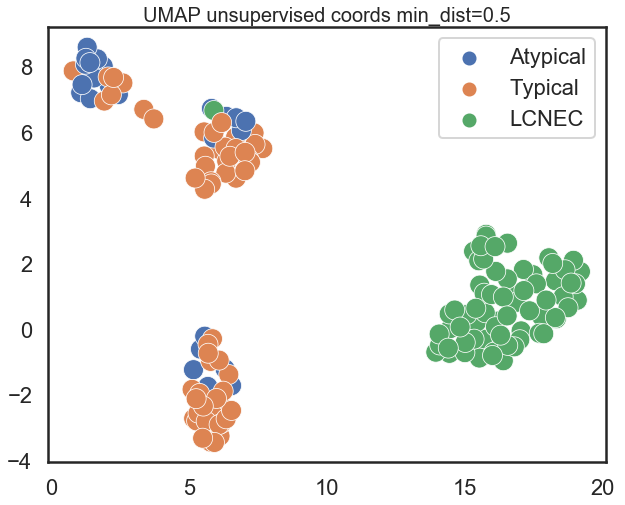

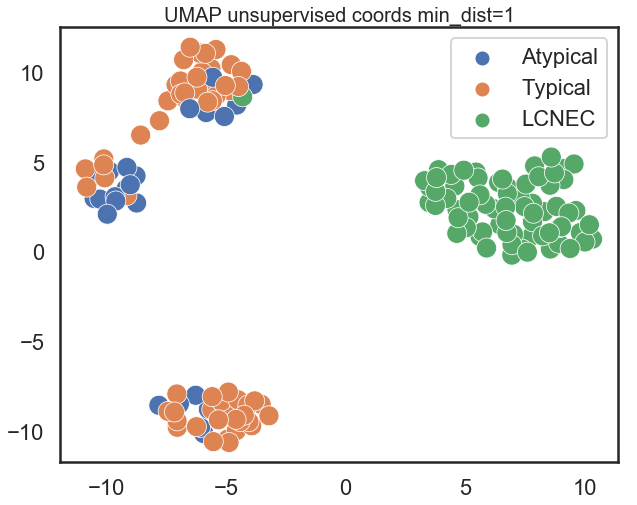

In [59]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_0 = umap.UMAP(min_dist=0).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_0[:, 0], y=standard_embedding_0[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_05 = umap.UMAP(min_dist=0.5).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_05[:, 0], y=standard_embedding_05[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0.5",  fontsize=20)
plt.show()
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=1).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=1",  fontsize=20)
plt.show()

**The default value for min_dist (as used above) is 0.1. We will look at a range of values from 0.0 through to 0.99.**

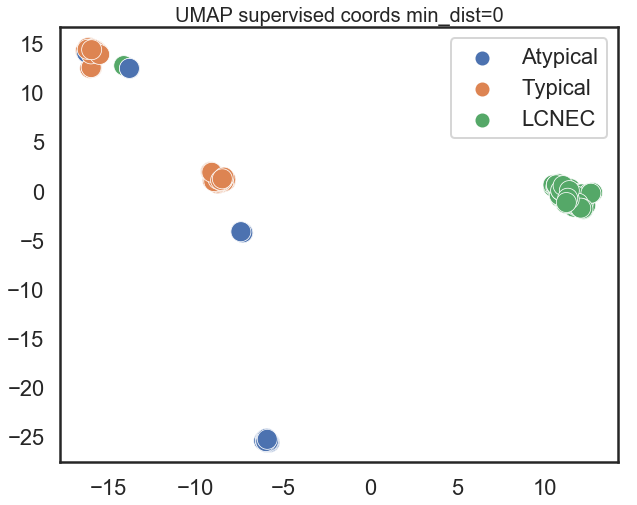

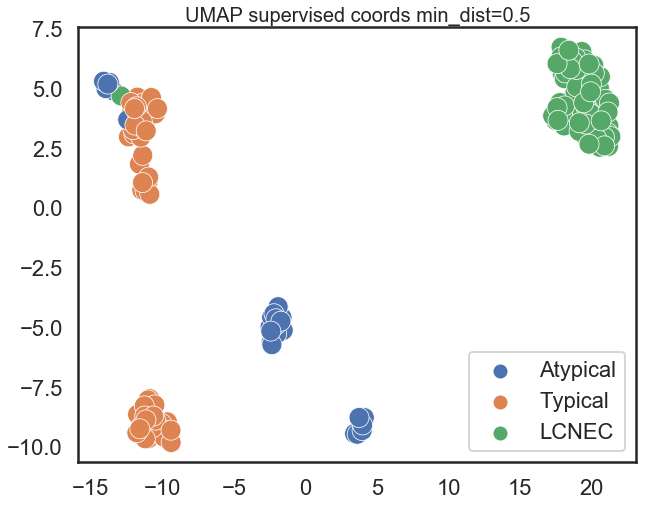

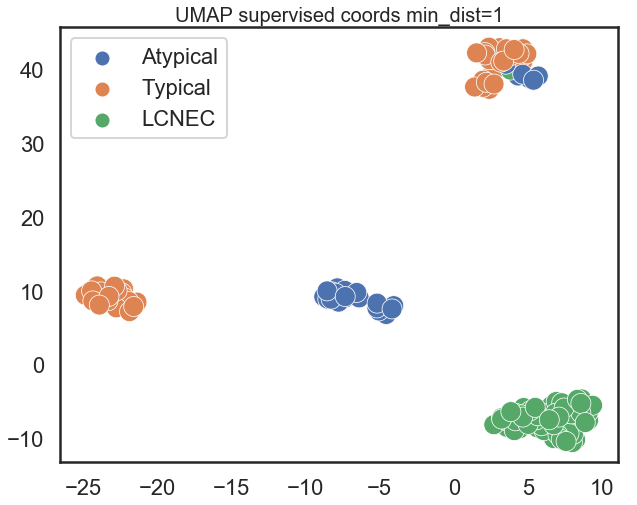

In [60]:
embedding_MD_0 = umap.UMAP(min_dist=0).fit_transform(lv_50_data, y=typeN)
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
sns.scatterplot(x=embedding_MD_0[:, 0], y=embedding_MD_0[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP supervised coords min_dist=0",  fontsize=20)
plt.show()

embedding_MD_05 = umap.UMAP(min_dist=0.5).fit_transform(lv_50_data, y=typeN)
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
sns.scatterplot(x=embedding_MD_05[:, 0], y=embedding_MD_05[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP supervised coords min_dist=0.5",  fontsize=20)
plt.show()

embedding_MD_1 = umap.UMAP(min_dist=1).fit_transform(lv_50_data, y=typeN)
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.set_context("poster", font_scale = 1)
sns.scatterplot(x=embedding_MD_1[:, 0], y=embedding_MD_1[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP supervised coords min_dist=1",  fontsize=20)
plt.show()

## Neighborhood preservation

### Distance

In [61]:
standard_embedding_0_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_0_df['X'] = standard_embedding_0[:,0]
standard_embedding_0_df['Y'] = standard_embedding_0[:,1]

standard_embedding_05_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_05_df['X'] = standard_embedding_05[:,0]
standard_embedding_05_df['Y'] = standard_embedding_05[:,1]

standard_embedding_1_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
standard_embedding_1_df['X'] = standard_embedding_1[:,0]
standard_embedding_1_df['Y'] = standard_embedding_1[:,1]

d_umap_md_0 =  Neighborhood.distance_matrix(standard_embedding_0_df)
d_umap_md_05 =  Neighborhood.distance_matrix(standard_embedding_05_df)
d_umap_md_1 =  Neighborhood.distance_matrix(standard_embedding_1_df)


d_mofa_expr = Neighborhood.distance_matrix(coords_mofa_expr_lnen)

Dist_pulmonary =  pd.read_csv("Distance_pulmo.txt", sep="\t") # "real distances" in Rn

In [62]:
coords_mofa_expr_lnen.head()
Sample_ID_df =pd.DataFrame(data_lv_50_type3["Sample_ID"] )
coords_mofa_expr_lnen_v2 = pd.merge(coords_mofa_expr_lnen, Sample_ID_df, on='Sample_ID', how='inner')
coords_mofa_expr_lnen = coords_mofa_expr_lnen_v2

## Writing

In [63]:
#standard_embedding_0_df.to_csv(path_or_buf='umap_md_0_coord.txt', sep='\t')
#standard_embedding_05_df.to_csv(path_or_buf='umap_md_05_coord.txt', sep='\t')
#standard_embedding_1_df.to_csv(path_or_buf='umap_md_1_coord.txt', sep='\t')

# CP

In [64]:
# cp0 = Neighborhood.centrality_preservation(d_umap_md_0 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),10),"CP_pulmo_R_UMAP_MD0")
#cp05 = Neighborhood.centrality_preservation(d_umap_md_05 ,  Dist_pulmonary , range(1,len(standard_embedding_05[:,0]),10),"CP_pulmo_R_UMAP_MD05")
#cp1 = Neighborhood.centrality_preservation(d_umap_md_1 ,  Dist_pulmonary , range(1,len(standard_embedding_1[:,0]),10),"CP_pulmo_R_UMAP_MD1")


![CPMinDist](cp_min_dist_v2.png)

# Seq Set

In [65]:
#Neighborhood.main_f(d_umap_md_0 , Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_R_UMAP_MD0" , "seq_diff_pulmo_R_UMAP_MD0" , True )
#Neighborhood.main_f(d_umap_md_05, Dist_pulmonary, d_supervised.shape[0] , "set_diff_pulmo_R_UMAP_MD05" , "seq_diff_pulmo_R_UMAP_MD05" , True )
#Neighborhood.main_f(d_umap_md_1, Dist_pulmonary, d_mofa_expr.shape[0] , "set_diff_pulmo_R_UMAP_MD1" , "seq_diff_pulmo_R_UMAP_MD1" , True )

In [66]:
#Neighborhood.main_f(d_umap_md_1, Dist_pulmonary, d_mofa_expr.shape[0] , "set_diff_pulmo_R_UMAP_MD1" , "seq_diff_pulmo_R_UMAP_MD1" , True )

![set_diff_min_dist_v2](set_diff_min_dist_v2.png)

![seq_diff_v2](seq_diff_v2.png)
![seq_diff_min_dist_log](seq_diff_min_dist_log.png)

## Clustering

In [67]:
min_dist_test = [0,0.5,1,2.5]
knn_acc_no_prepro =[]
svc_acc_no_prepro =[]
kmeans_acc_no_prepro =[]
for j  in range(5):
    CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )
    X_train = CV[0]
    X_test = CV[1]
    y_train = CV[2]
    y_test = CV[3]
        
    knn_1 = KNeighborsClassifier().fit(X_train, y_train)
    svc_1 = SVC().fit(X_train, y_train)
    kmeans_1 = KMeans(n_clusters=3).fit(X_train)
    knn_1.fit(X_train, y_train)
    pred_knn_1 = knn_1.predict(X_test)
    pred_kmeans_1 = kmeans_1.predict(X_test)
    kmean_acc_1 , kmean_lab_1 =label_pred(y_test, pred_kmeans_1 )
    
    
    print("Knn accurancy  : ",knn_1.score(X_test, y_test))
    print("SVC accurancy  : ",svc_1.score(X_test, y_test))
    print("Kmeans accurancy  : ", kmean_acc_1)
    knn_acc_no_prepro.append(knn_1.score(X_test, y_test))  
    svc_acc_no_prepro.append(svc_1.score(X_test, y_test))
    kmeans_acc_no_prepro.append(kmean_acc_1)
        
        

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  3  2
LCNEC       18  0  0
Typical      0  6  9
acc_score [0.23684210526315788, 0.15789473684210525, 0.7894736842105263, 0.07894736842105263, 0.6842105263157895, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.7894736842105263


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  5  1
LCNEC       20  0  0
Typical      0  8  4
acc_score [0.10526315789473684, 0.21052631578947367, 0.7631578947368421, 0.13157894736842105, 0.7631578947368421, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.6578947368421053
Kmeans accurancy  :  0.7631578947368421


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    1   0   5
LCNEC       0  14   0
Typical     6   0  12
acc_score [0.7105263157894737, 0.02631578947368421, 0.3157894736842105, 0.15789473684210525, 0.13157894736842105, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.5263157894736842
Kmeans accurancy  :  0.7105263157894737


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   2  2
LCNEC       17   0  1
Typical      0  10  6
acc_score [0.15789473684210525, 0.2894736842105263, 0.6578947368421053, 0.07894736842105263, 0.7631578947368421, 0.05263157894736842]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.7105263157894737
Kmeans accurancy  :  0.7631578947368421


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    2   0   2
LCNEC       0  15   0
Typical     9   0  10
acc_score [0.7105263157894737, 0.05263157894736842, 0.2631578947368421, 0.23684210526315788, 0.05263157894736842, 0.6842105263157895]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.6578947368421053
Kmeans accurancy  :  0.7105263157894737


In [68]:
list_clustering=["knn_acc"]*5 + ["svc_acc"]*5 + ["kmeans_acc"]*5
Acc_val = knn_acc_no_prepro + svc_acc_no_prepro + kmeans_acc_no_prepro

clustering_res_no_preprocessing = pd.DataFrame() 
clustering_res_no_preprocessing['clustering_method'] = list_clustering
clustering_res_no_preprocessing['Acc_val'] = Acc_val
clustering_res_no_preprocessing.shape

(15, 2)

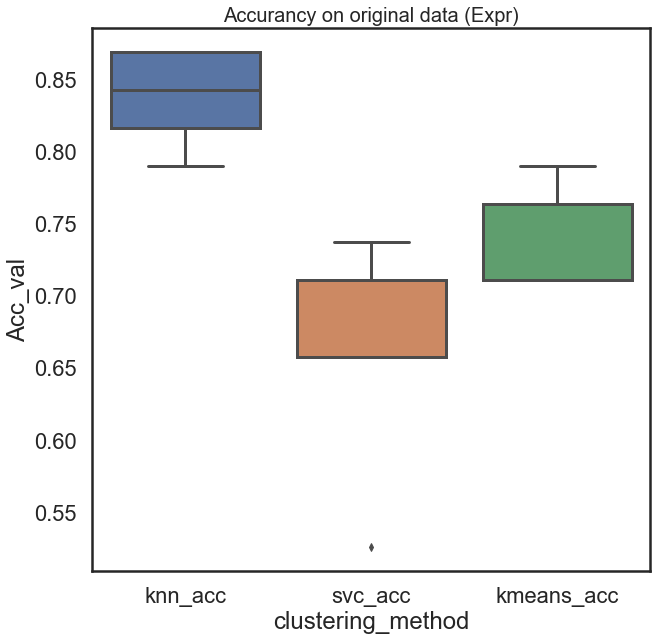

In [69]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res_no_preprocessing)
plt.title("Accurancy on original data (Expr)",  fontsize=20)
plt.show()

In [70]:
min_dist_test = [0,0.5,1]
min_dist = []
knn_acc = []
kmeans_acc = []
svc_acc = []

knn_silh = []
kmeans_silh = []
svc_silh = []



otp_spatial_cor_umap_md =[]
angptl3_spatial_cor_umap_md =[]
dendritic_cells_spatial_cor_umap_md = []

for i in min_dist_test :
    print('\n')
    print('i', i)
    for j  in range(5):
        CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )
        X_train = CV[0]
        X_test = CV[1]
        y_train = CV[2]
        y_test = CV[3]
        
        trans = umap.UMAP(min_dist = i).fit(X_train)
        svc_2 = SVC().fit(trans.embedding_, y_train)
        knn_2 = KNeighborsClassifier().fit(trans.embedding_, y_train)
        kmeans_2 = KMeans(n_clusters=3).fit(trans.embedding_, y_train)
        
        test_embedding = trans.transform(X_test)
        svc_pred_2= svc_2.predict(test_embedding)
        knn_pred_2 = knn_2.predict(test_embedding)
        kmeans_pred_2 = kmeans_2.predict(test_embedding)
        
        kmean_acc_2 , kmean_lab_2 =label_pred(y_test, kmeans_pred_2 )
        
        print("Knn accurancy  : ",knn_2.score(trans.transform(X_test), y_test) )
        print("SVC accurancy  : ",svc_2.score(trans.transform(X_test), y_test) )
        print("Kmeans accurancy  : ",kmean_acc_2 )
        
        print("Knn silhouette score  : ",silhouette_score(trans.transform(X_test), knn_pred_2) )
        print("Svc silhouette score  : ",silhouette_score(trans.transform(X_test), svc_pred_2) )
        print("Kmeans silhouette score  : ",silhouette_score(trans.transform(X_test), kmeans_pred_2) )
        
        min_dist.append(i)
        knn_acc.append(knn_2.score(trans.transform(X_test), y_test))
        svc_acc.append(svc_2.score(trans.transform(X_test), y_test))
        kmeans_acc.append(kmean_acc_2)
        
        knn_silh.append(silhouette_score(trans.transform(X_test), knn_pred_2))
        svc_silh.append(silhouette_score(trans.transform(X_test), svc_pred_2))
        kmeans_silh.append(silhouette_score(trans.transform(X_test), kmeans_pred_2))
       
        wknn10 = pysal.knnW(test_embedding, k = 10)
    
        OTP_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
        ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
        dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])
    
        mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
        otp_spatial_cor_umap_md.append(mi_otp.I)


        mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
        angptl3_spatial_cor_umap_md.append(mi_angptl3.I)
 

        mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
        dendritic_cells_spatial_cor_umap_md.append(mi_dendritic_cell.I)
    
    
    

        



i 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  2
LCNEC       0  15  1
Typical     8   0  8
acc_score [0.7105263157894737, 0.13157894736842105, 0.21052631578947367, 0.23684210526315788, 0.05263157894736842, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.4823607
Svc silhouette score  :  0.60314196
Kmeans silhouette score  :  0.87710744


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  6  0
LCNEC       15  0  0
Typical      0  9  8
acc_score [0.21052631578947367, 0.23684210526315788, 0.7631578947368421, 0.15789473684210525, 0.631578947368421, 0.0]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.52756095
Svc silhouette score  :  0.61667484
Kmeans silhouette score  :  0.81171244


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    1   0  3
LCNEC       0  17  0
Typical     8   0  9
acc_score [0.7105263157894737, 0.02631578947368421, 0.23684210526315788, 0.21052631578947367, 0.07894736842105263, 0.7368421052631579]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.53415483
Svc silhouette score  :  0.5817873
Kmeans silhouette score  :  0.7903699


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    1   0   3
LCNEC       0  14   0
Typical     6   0  14
acc_score [0.7631578947368421, 0.02631578947368421, 0.3684210526315789, 0.15789473684210525, 0.07894736842105263, 0.6052631578947368]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.22785942
Svc silhouette score  :  0.27210617
Kmeans silhouette score  :  0.9021938


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0  1   2
y_test              
Atypical    1  5   0
LCNEC       0  0  19
Typical     6  7   0
acc_score [0.02631578947368421, 0.7105263157894737, 0.13157894736842105, 0.7894736842105263, 0.18421052631578946, 0.15789473684210525]
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.4253499
Svc silhouette score  :  0.63775134
Kmeans silhouette score  :  0.8603714


i 0.5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     2   0  0
LCNEC        0  18  1
Typical     10   0  7
acc_score [0.7105263157894737, 0.07894736842105263, 0.18421052631578946, 0.2894736842105263, 0.0, 0.7368421052631579]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.45290273
Svc silhouette score  :  0.45780754
Kmeans silhouette score  :  0.7820573


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     2  0   0
LCNEC        1  0  19
Typical     10  6   0
acc_score [0.05263157894736842, 0.7105263157894737, 0.02631578947368421, 0.7631578947368421, 0.18421052631578946, 0.2631578947368421]
c_dict {1: 'Atypical', 2: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.53105557
Svc silhouette score  :  0.72067404
Kmeans silhouette score  :  0.7579544


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    6   0  4
LCNEC       0  16  0
Typical     6   0  6
acc_score [0.7368421052631579, 0.15789473684210525, 0.15789473684210525, 0.15789473684210525, 0.10526315789473684, 0.6842105263157895]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.7631578947368421
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.46280736
Svc silhouette score  :  0.3011202
Kmeans silhouette score  :  0.8365564


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  4  4
LCNEC       15  0  0
Typical      0  8  7
acc_score [0.18421052631578946, 0.21052631578947367, 0.6842105263157895, 0.10526315789473684, 0.7105263157894737, 0.10526315789473684]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.4136193
Svc silhouette score  :  0.4136193
Kmeans silhouette score  :  0.59232026


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  5  1
LCNEC       22  0  0
Typical      0  6  4
acc_score [0.10526315789473684, 0.15789473684210525, 0.8157894736842105, 0.13157894736842105, 0.7631578947368421, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.9473684210526315
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.5834059
Svc silhouette score  :  0.48476133
Kmeans silhouette score  :  0.826778


i 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  3  3
LCNEC       17  1  0
Typical      0  9  5
acc_score [0.15789473684210525, 0.23684210526315788, 0.6578947368421053, 0.07894736842105263, 0.7631578947368421, 0.10526315789473684]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.40272546
Svc silhouette score  :  0.41054034
Kmeans silhouette score  :  0.743985


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  4
LCNEC       1  18  0
Typical     3   0  8
acc_score [0.7894736842105263, 0.10526315789473684, 0.23684210526315788, 0.07894736842105263, 0.13157894736842105, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.6031701
Svc silhouette score  :  0.5515982
Kmeans silhouette score  :  0.8735212


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  5  3
LCNEC       19  0  0
Typical      0  6  5
acc_score [0.13157894736842105, 0.15789473684210525, 0.7631578947368421, 0.13157894736842105, 0.7368421052631579, 0.07894736842105263]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.5655364
Svc silhouette score  :  0.5655364
Kmeans silhouette score  :  0.74356526


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  2
LCNEC       1  19  0
Typical     7   0  5
acc_score [0.7368421052631579, 0.10526315789473684, 0.15789473684210525, 0.18421052631578946, 0.07894736842105263, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.56267184
Svc silhouette score  :  0.5102662
Kmeans silhouette score  :  0.8204861


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     2  0  2
LCNEC       21  0  0
Typical      7  5  1
acc_score [0.07894736842105263, 0.18421052631578946, 0.5789473684210527, 0.18421052631578946, 0.7368421052631579, 0.23684210526315788]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.9473684210526315
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.43608594
Svc silhouette score  :  0.367435
Kmeans silhouette score  :  0.6828404


In [71]:
list_clustering=["knn_acc"]*len(knn_acc) + ["svc_acc"]*len(knn_acc) + ["kmeans_acc"]*len(knn_acc)
Acc_val = knn_acc + svc_acc + kmeans_acc
Sihl_val = knn_silh + svc_silh+ kmeans_silh
Min_dist_val = min_dist + min_dist + min_dist

In [72]:
clustering_res = pd.DataFrame() 
clustering_res['clustering_method'] = list_clustering
clustering_res['Acc_val'] = Acc_val
clustering_res['Silh_val'] = Sihl_val
clustering_res['min_dist'] = Min_dist_val
#clustering_res.shape
#clustering_res.head

In [73]:
list_spatial_cor_umap_md = ["otp"]*len(otp_spatial_cor_umap_md) + ["angptl3"]*len(otp_spatial_cor_umap_md) + ["dendritic_cell"]*len(otp_spatial_cor_umap_md)
spatial_cor_val_umap_md = otp_spatial_cor_umap_md + angptl3_spatial_cor_umap_md + dendritic_cells_spatial_cor_umap_md
spatial_cor_umap_md = pd.DataFrame() 
spatial_cor_umap_md['list_spatial_cor'] = list_spatial_cor_umap_md
spatial_cor_umap_md ['spatial_cor_val'] = spatial_cor_val_umap_md
spatial_cor_umap_md ['min_dist'] =Min_dist_val
spatial_cor_umap_md.shape



(45, 3)

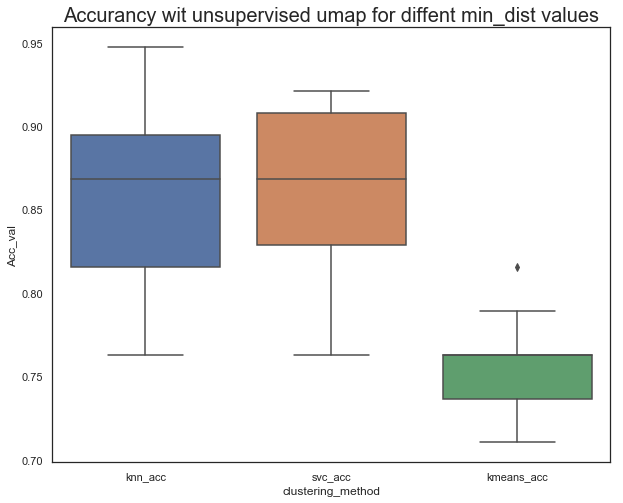

In [74]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.boxplot(x="clustering_method", y="Acc_val", data=clustering_res)
plt.title("Accurancy wit unsupervised umap for diffent min_dist values",  fontsize=20)
plt.show()

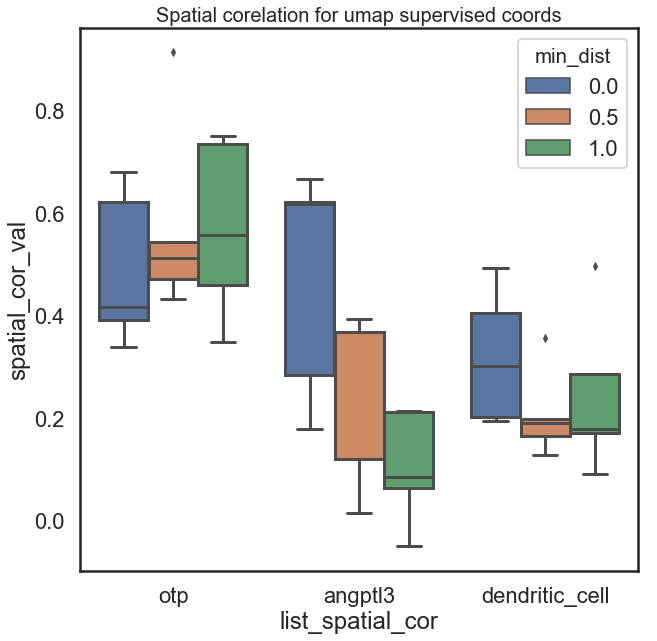

In [75]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="list_spatial_cor", y="spatial_cor_val", hue="min_dist",data=spatial_cor_umap_md)
plt.title("Spatial corelation for umap supervised coords",  fontsize=20)
plt.show()

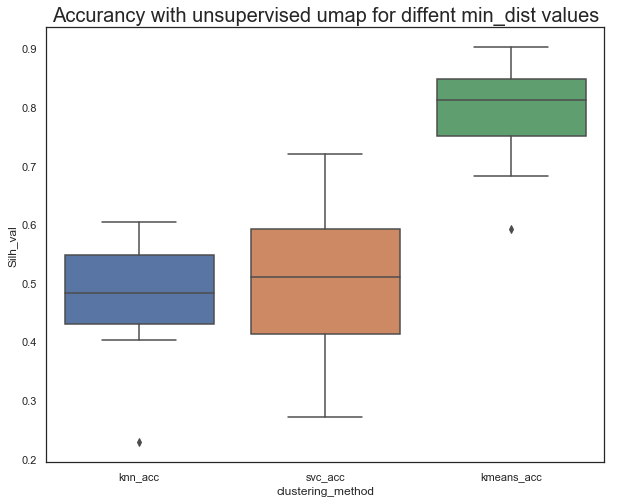

In [76]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.boxplot(x="clustering_method", y="Silh_val", data=clustering_res)
plt.title("Accurancy with unsupervised umap for diffent min_dist values",  fontsize=20)
plt.show()

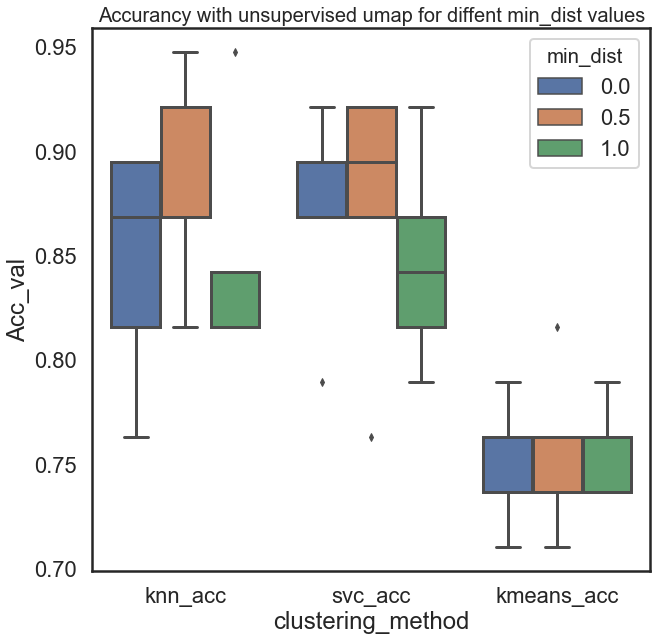

In [77]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="clustering_method", y="Acc_val", hue="min_dist", data=clustering_res)
plt.title("Accurancy with unsupervised umap for diffent min_dist values",  fontsize=20)
plt.show()

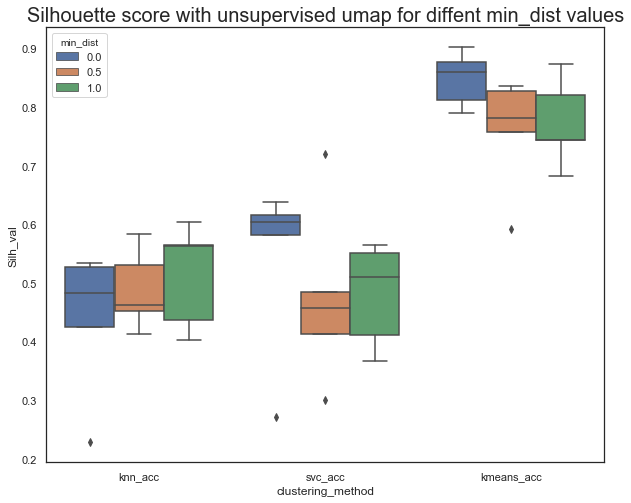

In [78]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
sns.boxplot(x="clustering_method", y="Silh_val", hue="min_dist", data=clustering_res)
plt.title("Silhouette score with unsupervised umap for diffent min_dist values",  fontsize=20)
plt.show()

# Min dist + N_neighbors

In [79]:
min_dist_test = [0,0.5,1]
n_neighbors_test  = [2, 10,50,100 ]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 25 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


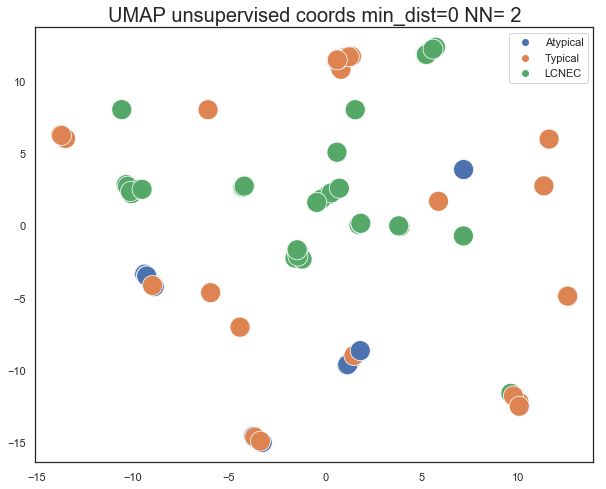

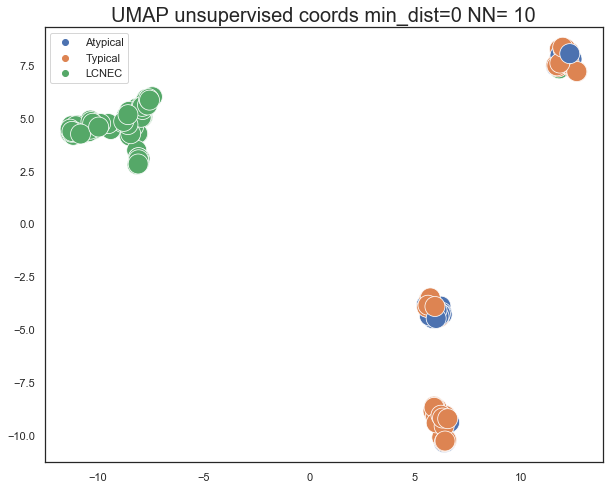

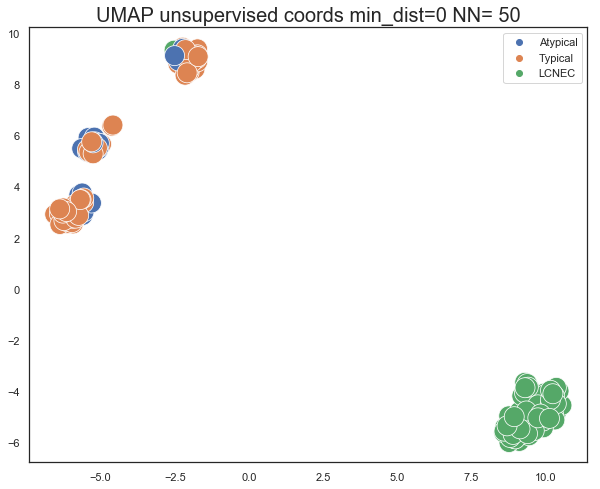

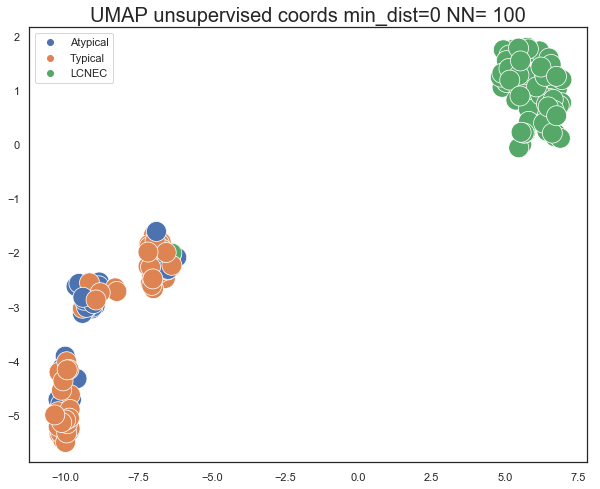

In [80]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_0 = umap.UMAP(min_dist=0, n_neighbors = 2).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_0[:, 0], y=standard_embedding_0[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0 NN= 2",  fontsize=20)
plt.show()


sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_05 = umap.UMAP(min_dist=0,  n_neighbors = 10).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_05[:, 0], y=standard_embedding_05[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0 NN= 10",  fontsize=20)
plt.show()

sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=0,  n_neighbors = 50).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0 NN= 50",  fontsize=20)
plt.show()

sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=0,  n_neighbors = 100).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.title("UMAP unsupervised coords min_dist=0 NN= 100",  fontsize=20)
plt.show()

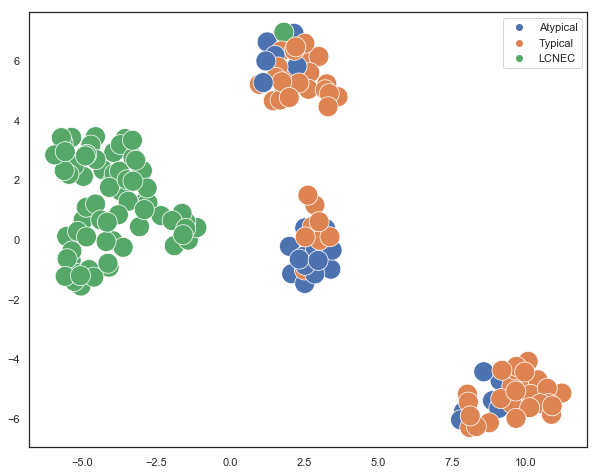

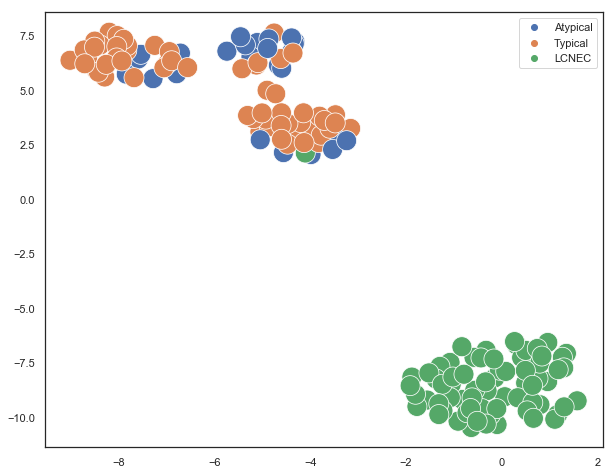

In [81]:
lv_50_data = data_lv_50_type3.iloc[:,1:6398]

sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_05 = umap.UMAP(min_dist=0.5,  n_neighbors = 10).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_05[:, 0], y=standard_embedding_05[:, 1],  hue=lv_50_type, s=400)
plt.show()
sns.set(style='white', rc={'figure.figsize':(10,8)})
lv_50_data = data_lv_50_type3.iloc[:,1:6398]
#lv_50_type = data_lv_50_type3.iloc[:,6399]
standard_embedding_1 = umap.UMAP(min_dist=0.5,  n_neighbors = 50).fit_transform(lv_50_data)
sns.scatterplot(x=standard_embedding_1[:, 0], y=standard_embedding_1[:, 1],  hue=lv_50_type, s=400)
plt.show()

## Neighborhood preservation

### Distance

In [82]:

embedding_MD_0_NN2 = umap.UMAP(min_dist=0, n_neighbors=2).fit_transform(lv_50_data, y=typeN)
embedding_MD_0_NN10 = umap.UMAP(min_dist=0, n_neighbors=10).fit_transform(lv_50_data, y=typeN)
embedding_MD_0_NN50 = umap.UMAP(min_dist=0, n_neighbors=50).fit_transform(lv_50_data, y=typeN)
embedding_MD_0_NN100 = umap.UMAP(min_dist=0, n_neighbors=100).fit_transform(lv_50_data, y=typeN)

embedding_MD_05_NN2 = umap.UMAP(min_dist=0.5, n_neighbors=2).fit_transform(lv_50_data, y=typeN)
embedding_MD_05_NN10 = umap.UMAP(min_dist=0.5, n_neighbors=10).fit_transform(lv_50_data, y=typeN)
embedding_MD_05_NN50 = umap.UMAP(min_dist=0.5, n_neighbors=50).fit_transform(lv_50_data, y=typeN)
embedding_MD_05_NN100 = umap.UMAP(min_dist=0.5, n_neighbors=100).fit_transform(lv_50_data, y=typeN)

embedding_MD_1_NN2 = umap.UMAP(min_dist=1, n_neighbors=2).fit_transform(lv_50_data, y=typeN)
embedding_MD_1_NN10 = umap.UMAP(min_dist=1, n_neighbors=10).fit_transform(lv_50_data, y=typeN)
embedding_MD_1_NN50 = umap.UMAP(min_dist=1, n_neighbors=50).fit_transform(lv_50_data, y=typeN)
embedding_MD_1_NN100 = umap.UMAP(min_dist=1, n_neighbors=100).fit_transform(lv_50_data, y=typeN)

###
embedding_MD_0_NN2_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN2_df['X'] = embedding_MD_0_NN2[:,0]
embedding_MD_0_NN2_df['Y'] = embedding_MD_0_NN2[:,1]

embedding_MD_0_NN10_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN10_df['X'] = embedding_MD_0_NN10[:,0]
embedding_MD_0_NN10_df['Y'] = embedding_MD_0_NN10[:,1]

embedding_MD_0_NN50_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN50_df['X'] = embedding_MD_0_NN50[:,0]
embedding_MD_0_NN50_df['Y'] = embedding_MD_0_NN50[:,1]

embedding_MD_0_NN100_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_0_NN100_df['X'] = embedding_MD_0_NN100[:,0]
embedding_MD_0_NN100_df['Y'] = embedding_MD_0_NN100[:,1]


d_umap_md_0_nn2 =  Neighborhood.distance_matrix(embedding_MD_0_NN2_df)
d_umap_md_0_nn10 =  Neighborhood.distance_matrix(embedding_MD_0_NN10_df)
d_umap_md_0_nn50 =  Neighborhood.distance_matrix(embedding_MD_0_NN50_df)
d_umap_md_0_nn100 =  Neighborhood.distance_matrix(embedding_MD_0_NN100_df)


##


embedding_MD_05_NN2_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN2_df['X'] = embedding_MD_05_NN2[:,0]
embedding_MD_05_NN2_df['Y'] = embedding_MD_05_NN2[:,1]

embedding_MD_05_NN10_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN10_df['X'] = embedding_MD_05_NN10[:,0]
embedding_MD_05_NN10_df['Y'] = embedding_MD_05_NN10[:,1]

embedding_MD_05_NN50_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN50_df['X'] = embedding_MD_05_NN50[:,0]
embedding_MD_05_NN50_df['Y'] = embedding_MD_05_NN50[:,1]

embedding_MD_05_NN100_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_05_NN100_df['X'] = embedding_MD_05_NN100[:,0]
embedding_MD_05_NN100_df['Y'] = embedding_MD_05_NN100[:,1]

d_umap_md_05_nn2 =  Neighborhood.distance_matrix(embedding_MD_05_NN2_df)
d_umap_md_05_nn10 =  Neighborhood.distance_matrix(embedding_MD_05_NN10_df)
d_umap_md_05_nn50 =  Neighborhood.distance_matrix(embedding_MD_05_NN50_df)
d_umap_md_05_nn100 =  Neighborhood.distance_matrix(embedding_MD_05_NN100_df)

####

embedding_MD_1_NN2_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN2_df['X'] = embedding_MD_1_NN2[:,0]
embedding_MD_1_NN2_df['Y'] = embedding_MD_1_NN2[:,1]

embedding_MD_1_NN10_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN10_df['X'] = embedding_MD_1_NN10[:,0]
embedding_MD_1_NN10_df['Y'] = embedding_MD_1_NN10[:,1]

embedding_MD_1_NN50_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN50_df['X'] = embedding_MD_1_NN50[:,0]
embedding_MD_1_NN50_df['Y'] = embedding_MD_1_NN50[:,1]

embedding_MD_1_NN100_df=  pd.DataFrame(data_lv_50_type3.iloc[:,0])
embedding_MD_1_NN100_df['X'] = embedding_MD_1_NN100[:,0]
embedding_MD_1_NN100_df['Y'] = embedding_MD_1_NN100[:,1]

d_umap_md_1_nn2 =  Neighborhood.distance_matrix(embedding_MD_1_NN2_df)
d_umap_md_1_nn10 =  Neighborhood.distance_matrix(embedding_MD_1_NN10_df)
d_umap_md_1_nn50 =  Neighborhood.distance_matrix(embedding_MD_1_NN50_df)
d_umap_md_1_nn100 =  Neighborhood.distance_matrix(embedding_MD_1_NN100_df)

##

d_mofa_expr = Neighborhood.distance_matrix(coords_mofa_expr_lnen)

Dist_pulmonary =  pd.read_csv("Distance_pulmo.txt", sep="\t") # "real distances" in Rn



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 25 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: 

## Writing

In [83]:
"""
embedding_MD_0_NN2_df.to_csv(path_or_buf='umap_MD_0_NN2_coords.txt', sep='\t')
embedding_MD_0_NN10_df.to_csv(path_or_buf='umap_MD_0_NN10_coords.txt', sep='\t')
embedding_MD_0_NN50_df.to_csv(path_or_buf='umap_MD_0_NN50_coords.txt', sep='\t')
embedding_MD_0_NN100_df.to_csv(path_or_buf='umap_MD_0_NN100_coords.txt', sep='\t')


embedding_MD_05_NN2_df.to_csv(path_or_buf='umap_MD_05_NN2_coords.txt', sep='\t')
embedding_MD_05_NN10_df.to_csv(path_or_buf='umap_MD_05_NN10_coords.txt', sep='\t')
embedding_MD_05_NN50_df.to_csv(path_or_buf='umap_MD_05_NN50_coords.txt', sep='\t')
embedding_MD_05_NN100_df.to_csv(path_or_buf='umap_MD_05_NN100_coords.txt', sep='\t')


embedding_MD_1_NN2_df.to_csv(path_or_buf='umap_MD_1_NN2_coords.txt', sep='\t')
embedding_MD_1_NN10_df.to_csv(path_or_buf='umap_MD_1_NN10_coords.txt', sep='\t')
embedding_MD_1_NN50_df.to_csv(path_or_buf='umap_MD_1_NN50_coords.txt', sep='\t')
embedding_MD_1_NN100_df.to_csv(path_or_buf='umap_MD_1_NN100_coords.txt', sep='\t')
"""

"\nembedding_MD_0_NN2_df.to_csv(path_or_buf='umap_MD_0_NN2_coords.txt', sep='\t')\nembedding_MD_0_NN10_df.to_csv(path_or_buf='umap_MD_0_NN10_coords.txt', sep='\t')\nembedding_MD_0_NN50_df.to_csv(path_or_buf='umap_MD_0_NN50_coords.txt', sep='\t')\nembedding_MD_0_NN100_df.to_csv(path_or_buf='umap_MD_0_NN100_coords.txt', sep='\t')\n\n\nembedding_MD_05_NN2_df.to_csv(path_or_buf='umap_MD_05_NN2_coords.txt', sep='\t')\nembedding_MD_05_NN10_df.to_csv(path_or_buf='umap_MD_05_NN10_coords.txt', sep='\t')\nembedding_MD_05_NN50_df.to_csv(path_or_buf='umap_MD_05_NN50_coords.txt', sep='\t')\nembedding_MD_05_NN100_df.to_csv(path_or_buf='umap_MD_05_NN100_coords.txt', sep='\t')\n\n\nembedding_MD_1_NN2_df.to_csv(path_or_buf='umap_MD_1_NN2_coords.txt', sep='\t')\nembedding_MD_1_NN10_df.to_csv(path_or_buf='umap_MD_1_NN10_coords.txt', sep='\t')\nembedding_MD_1_NN50_df.to_csv(path_or_buf='umap_MD_1_NN50_coords.txt', sep='\t')\nembedding_MD_1_NN100_df.to_csv(path_or_buf='umap_MD_1_NN100_coords.txt', sep='\t'

# CP

In [84]:
#cp_MD_0_NN2 = Neighborhood.centrality_preservation(d_umap_md_0_nn2 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN2")

#cp_MD_0_NN10 = Neighborhood.centrality_preservation(d_umap_md_0_nn10 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN10")
#cp_MD_0_NN50 = Neighborhood.centrality_preservation(d_umap_md_0_nn50 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN50")
#cp_MD_0_NN100 = Neighborhood.centrality_preservation(d_umap_md_0_nn100 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD0_NN100")

#cp_MD_05_NN10 = Neighborhood.centrality_preservation(d_umap_md_05_nn10 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD05_NN10")
#cp_MD_05_NN50 = Neighborhood.centrality_preservation(d_umap_md_05_nn50 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD05_NN50")
#cp_MD_05_NN100 = Neighborhood.centrality_preservation(d_umap_md_05_nn100 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD05_NN100")

#cp_MD_1_NN10 = Neighborhood.centrality_preservation(d_umap_md_1_nn10 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD1_NN10")
#cp_MD_1_NN50 = Neighborhood.centrality_preservation(d_umap_md_1_nn50 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD1_NN50")
#cp_MD_1_NN100 = Neighborhood.centrality_preservation(d_umap_md_1_nn100 ,  Dist_pulmonary , range(1,len(standard_embedding_0[:,0]),20),"CP_pulmo_R_UMAP_MD1_NN100")


#cp_PCA_R = Neighborhood.centrality_preservation(d_mofa_expr , Dist_pulmonary ,  range(1,len(standard_embedding_0[:,0]),20)  ,"CP_pulmo_R_MOFA_by_20")

![cp_md_NN_all](cp_md_NN_all.png)
![CP_MD0_NNN](CP_MD0_NNN.png)
![cp_md_05_nn](cp_md_05_nn.png)
![cp_MD_1_NN](cp_MD_1_NN.png)

## Set - Seq

In [85]:
#Neighborhood.main_f(d_umap_md_0_nn10 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN10" , "seq_diff_pulmo_R_UMAP_MD0_NN10" , True )

In [86]:
#Neighborhood.main_f(d_umap_md_0_nn50 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN50" , "seq_diff_pulmo_R_UMAP_MD0_NN50" , True )
#Neighborhood.main_f(d_umap_md_0_nn100 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD0_NN100" , "seq_diff_pulmo_R_UMAP_MD0_NN100" , True )

#Neighborhood.main_f(d_umap_md_05_nn10 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD05_NN10" , "seq_diff_pulmo_R_UMAP_MD05_NN10" , True )
#Neighborhood.main_f(d_umap_md_05_nn50 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD05_NN50" , "seq_diff_pulmo_R_UMAP_MD05_NN50" , True )
#Neighborhood.main_f(d_umap_md_05_nn100 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD05_NN100" , "seq_diff_pulmo_R_UMAP_MD05_NN100" , True )

#Neighborhood.main_f(d_umap_md_1_nn10 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD1_NN10" , "seq_diff_pulmo_R_UMAP_MD1_NN10" , True )
#Neighborhood.main_f(d_umap_md_1_nn50 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD1_NN50" , "seq_diff_pulmo_R_UMAP_MD1_NN50" , True )
#Neighborhood.main_f(d_umap_md_1_nn100 , Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_UMAP_MD1_NN100" , "seq_diff_pulmo_R_UMAP_MD1_NN100" , True )

#Neighborhood.main_f(d_mofa_expr, Dist_pulmonary, range(1,len(standard_embedding_0[:,0]),20) , "set_diff_pulmo_R_MOFA_by20" , "seq_diff_pulmo_R_MOFA_by20" , True )

![set_diff_md_nn_all](set_diff_md_nn_all_v2.png)
![set_diff_md0_nn](set_diff_md0_nn.png)
![set_diff_md05_nn](set_diff_md05_nn.png)
![set_diff_md1_Nn100.png](set_diff_md1_Nn100.png)

##### Sequence difference view

![seq_md_nn_all.png](seq_md_nn_all.png)


![seq_md0_nn.png](seq_md_0_nn.png)

![seq_md05_nn](seq_md05_nn.png)
![seq_md1_nn](seq_md1_nn.png)


In [184]:
min_dist_test = [0,0.5,1]
nn_test = [10,50,100]
min_dist = []
knn_acc = []
kmeans_acc = []
svc_acc = []

knn_silh = []
kmeans_silh = []
svc_silh = []


N_neighbors =[]
otp_spatial_cor_umap_md =[]
angptl3_spatial_cor_umap_md =[]
dendritic_cells_spatial_cor_umap_md = []

for i in min_dist_test :
    for j in nn_test:
        print('\n')
        print('i', i)
        for z  in range(5):
            CV = train_test_split(lv_50_data,lv_50_type,lv_50_type )
            X_train = CV[0]
            X_test = CV[1]
            y_train = CV[2]
            y_test = CV[3]
        
            trans = umap.UMAP(min_dist = i, n_neighbors = j ).fit(X_train)
            svc_2 = SVC().fit(trans.embedding_, y_train)
            knn_2 = KNeighborsClassifier().fit(trans.embedding_, y_train)
            kmeans_2 = KMeans(n_clusters=3).fit(trans.embedding_, y_train)
        
            test_embedding = trans.transform(X_test)
            svc_pred_2= svc_2.predict(test_embedding)
            knn_pred_2 = knn_2.predict(test_embedding)
            kmeans_pred_2 = kmeans_2.predict(test_embedding)
        
            kmean_acc_2 , kmean_lab_2 =label_pred(y_test, kmeans_pred_2 )
        
            print("Knn accurancy  : ",knn_2.score(trans.transform(X_test), y_test) )
            print("SVC accurancy  : ",svc_2.score(trans.transform(X_test), y_test) )
            print("Kmeans accurancy  : ",kmean_acc_2 )
        
            print("Knn silhouette score  : ",silhouette_score(trans.transform(X_test), knn_pred_2) )
            print("Svc silhouette score  : ",silhouette_score(trans.transform(X_test), svc_pred_2) )
            print("Kmeans silhouette score  : ",silhouette_score(trans.transform(X_test), kmeans_pred_2) )
        
            min_dist.append(i)
            N_neighbors.append(j)
            knn_acc.append(knn_2.score(trans.transform(X_test), y_test))
            svc_acc.append(svc_2.score(trans.transform(X_test), y_test))
            kmeans_acc.append(kmean_acc_2)
        
            knn_silh.append(silhouette_score(trans.transform(X_test), knn_pred_2))
            svc_silh.append(silhouette_score(trans.transform(X_test), svc_pred_2))
            kmeans_silh.append(silhouette_score(trans.transform(X_test), kmeans_pred_2))
       
            wknn10 = pysal.knnW(test_embedding, k = 10)
    
            OTP_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
            ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
            dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])
    
            mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
            otp_spatial_cor_umap_md.append(mi_otp.I)


            mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
            angptl3_spatial_cor_umap_md.append(mi_angptl3.I)
 

            mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
            dendritic_cells_spatial_cor_umap_md.append(mi_dendritic_cell.I)
    
    
    

        



i 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     0  2   1
LCNEC       17  0   0
Typical      0  8  10
acc_score [0.2631578947368421, 0.21052631578947367, 0.7631578947368421, 0.05263157894736842, 0.6842105263157895, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.47522545
Svc silhouette score  :  0.6011411
Kmeans silhouette score  :  0.84610957


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  6  1
LCNEC       17  0  0
Typical      0  9  5
acc_score [0.13157894736842105, 0.23684210526315788, 0.7368421052631579, 0.15789473684210525, 0.7105263157894737, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.55664045
Svc silhouette score  :  0.6039145
Kmeans silhouette score  :  0.81630856


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   3  2
LCNEC       18   1  0
Typical      0  11  3
acc_score [0.10526315789473684, 0.2894736842105263, 0.631578947368421, 0.07894736842105263, 0.8157894736842105, 0.07894736842105263]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.44856775
Svc silhouette score  :  0.44856775
Kmeans silhouette score  :  0.83303964


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     0  3   2
LCNEC       16  1   0
Typical      0  6  10
acc_score [0.2894736842105263, 0.15789473684210525, 0.7631578947368421, 0.07894736842105263, 0.631578947368421, 0.07894736842105263]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.55381787
Svc silhouette score  :  0.55381787
Kmeans silhouette score  :  0.87649804


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1   2
y_test                
Atypical     1   0   1
LCNEC        1  14   0
Typical     11   0  10
acc_score [0.6578947368421053, 0.02631578947368421, 0.2894736842105263, 0.2894736842105263, 0.05263157894736842, 0.6842105263157895]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.7368421052631579
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.6842105263157895
Knn silhouette score  :  0.41096613
Svc silhouette score  :  0.66991293
Kmeans silhouette score  :  0.8424945


i 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    6   0  2
LCNEC       0  15  0
Typical     8   0  7
acc_score [0.7368421052631579, 0.15789473684210525, 0.18421052631578946, 0.21052631578947367, 0.05263157894736842, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.3683361
Svc silhouette score  :  0.56589675
Kmeans silhouette score  :  0.6598999


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    8   0  1
LCNEC       0  19  1
Typical     7   0  2
acc_score [0.7631578947368421, 0.23684210526315788, 0.05263157894736842, 0.21052631578947367, 0.02631578947368421, 0.7105263157894737]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7105263157894737
SVC accurancy  :  0.7105263157894737
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.4078523
Svc silhouette score  :  0.39666685
Kmeans silhouette score  :  0.7529597


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  2  3
LCNEC       21  0  0
Typical      0  8  4
acc_score [0.10526315789473684, 0.21052631578947367, 0.7105263157894737, 0.05263157894736842, 0.8421052631578947, 0.07894736842105263]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.8421052631578947
Knn silhouette score  :  0.44366014
Svc silhouette score  :  0.44366014
Kmeans silhouette score  :  0.7875904


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    7   0  0
LCNEC       0  14  1
Typical     9   0  7
acc_score [0.7368421052631579, 0.21052631578947367, 0.18421052631578946, 0.2631578947368421, 0.0, 0.6052631578947368]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.9124605
Svc silhouette score  :  0.9124605
Kmeans silhouette score  :  0.66060024


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  3  1
LCNEC       15  0  1
Typical      0  9  9
acc_score [0.23684210526315788, 0.2631578947368421, 0.7105263157894737, 0.10526315789473684, 0.6578947368421053, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.51096386
Svc silhouette score  :  0.51096386
Kmeans silhouette score  :  0.80523217


i 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     2   0  4
LCNEC        0  16  0
Typical     13   0  3
acc_score [0.5526315789473685, 0.05263157894736842, 0.07894736842105263, 0.34210526315789475, 0.10526315789473684, 0.868421052631579]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.868421052631579
Knn silhouette score  :  0.68509257
Svc silhouette score  :  0.68509257
Kmeans silhouette score  :  0.61180764


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     0  2   6
LCNEC       13  0   0
Typical      0  7  10
acc_score [0.2631578947368421, 0.18421052631578946, 0.6578947368421053, 0.05263157894736842, 0.6842105263157895, 0.15789473684210525]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.7105263157894737
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.6842105263157895
Knn silhouette score  :  0.509034
Svc silhouette score  :  0.56539685
Kmeans silhouette score  :  0.36818084


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    6   0  4
LCNEC       0  14  0
Typical     7   0  7
acc_score [0.7105263157894737, 0.15789473684210525, 0.18421052631578946, 0.18421052631578946, 0.10526315789473684, 0.6578947368421053]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.7105263157894737
Knn silhouette score  :  0.28660712
Svc silhouette score  :  0.3564954
Kmeans silhouette score  :  0.50368774


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    3   0  2
LCNEC       0  22  0
Typical     8   0  3
acc_score [0.7368421052631579, 0.07894736842105263, 0.07894736842105263, 0.21052631578947367, 0.05263157894736842, 0.8421052631578947]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.8421052631578947
Knn silhouette score  :  0.8051288
Svc silhouette score  :  0.8051288
Kmeans silhouette score  :  0.5896779


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  3  4
LCNEC       20  0  0
Typical      0  5  6
acc_score [0.15789473684210525, 0.13157894736842105, 0.7631578947368421, 0.07894736842105263, 0.7631578947368421, 0.10526315789473684]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7105263157894737
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.54157245
Svc silhouette score  :  0.57126707
Kmeans silhouette score  :  0.6102781


i 0.5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    0   0  4
LCNEC       0  19  0
Typical     6   0  9
acc_score [0.7368421052631579, 0.0, 0.23684210526315788, 0.15789473684210525, 0.10526315789473684, 0.7631578947368421]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.4564332
Svc silhouette score  :  0.6649407
Kmeans silhouette score  :  0.8306017


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1   2
y_test                
Atypical     0   2   5
LCNEC       10   1   0
Typical      0  10  10
acc_score [0.2894736842105263, 0.2631578947368421, 0.5789473684210527, 0.05263157894736842, 0.6578947368421053, 0.15789473684210525]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.8947368421052632
Kmeans accurancy  :  0.6578947368421053
Knn silhouette score  :  0.31919718
Svc silhouette score  :  0.31919718
Kmeans silhouette score  :  0.79494137


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    8   0  1
LCNEC       0  14  1
Typical     7   0  7
acc_score [0.7631578947368421, 0.23684210526315788, 0.18421052631578946, 0.21052631578947367, 0.02631578947368421, 0.5789473684210527]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.4863863
Svc silhouette score  :  0.43409407
Kmeans silhouette score  :  0.7268151


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  8  1
LCNEC       19  1  0
Typical      0  5  4
acc_score [0.13157894736842105, 0.13157894736842105, 0.8157894736842105, 0.21052631578947367, 0.6578947368421053, 0.05263157894736842]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.34395975
Svc silhouette score  :  0.34508362
Kmeans silhouette score  :  0.78119874


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0  1   2
y_test              
Atypical    2  2   0
LCNEC       0  0  20
Typical     6  8   0
acc_score [0.05263157894736842, 0.7894736842105263, 0.05263157894736842, 0.7368421052631579, 0.21052631578947367, 0.15789473684210525]
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.47734776
Svc silhouette score  :  0.4319948
Kmeans silhouette score  :  0.78103244


i 0.5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    1   0  5
LCNEC       0  20  0
Typical     3   0  9
acc_score [0.7894736842105263, 0.02631578947368421, 0.23684210526315788, 0.07894736842105263, 0.13157894736842105, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.6842105263157895
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.67352813
Svc silhouette score  :  0.5710935
Kmeans silhouette score  :  0.61501014


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    1   0   5
LCNEC       0  16   0
Typical     5   0  11
acc_score [0.7368421052631579, 0.02631578947368421, 0.2894736842105263, 0.13157894736842105, 0.13157894736842105, 0.6842105263157895]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.34940037
Svc silhouette score  :  0.6455895
Kmeans silhouette score  :  0.38676006


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   2  3
LCNEC       16   0  1
Typical      0  12  4
acc_score [0.10526315789473684, 0.34210526315789475, 0.5789473684210527, 0.07894736842105263, 0.8157894736842105, 0.07894736842105263]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8421052631578947
SVC accurancy  :  0.8421052631578947
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.886758
Svc silhouette score  :  0.886758
Kmeans silhouette score  :  0.5084214


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  1  5
LCNEC       19  1  0
Typical      0  8  4
acc_score [0.13157894736842105, 0.21052631578947367, 0.631578947368421, 0.02631578947368421, 0.8421052631578947, 0.15789473684210525]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.8421052631578947
Knn silhouette score  :  0.5298468
Svc silhouette score  :  0.49884906
Kmeans silhouette score  :  0.5663402


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    6   0  2
LCNEC       0  18  1
Typical     6   0  5
acc_score [0.7631578947368421, 0.18421052631578946, 0.13157894736842105, 0.18421052631578946, 0.05263157894736842, 0.6842105263157895]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7631578947368421
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.14160945
Svc silhouette score  :  0.77054614
Kmeans silhouette score  :  0.5725766


i 0.5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    3   0  2
LCNEC       8  10  0
Typical     6   0  9
acc_score [0.5789473684210527, 0.07894736842105263, 0.4473684210526316, 0.15789473684210525, 0.2631578947368421, 0.47368421052631576]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.5789473684210527
Knn silhouette score  :  0.23824863
Svc silhouette score  :  0.20462748
Kmeans silhouette score  :  0.46780434


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0  1   2
y_test              
Atypical    0  4   6
LCNEC       6  0  10
Typical     0  7   5
acc_score [0.13157894736842105, 0.4473684210526316, 0.39473684210526316, 0.3684210526315789, 0.5, 0.15789473684210525]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.7368421052631579
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.5
Knn silhouette score  :  0.24651252
Svc silhouette score  :  0.38807106
Kmeans silhouette score  :  0.266629


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   0  2
LCNEC       4  16  0
Typical     6   0  8
acc_score [0.6842105263157895, 0.05263157894736842, 0.3157894736842105, 0.15789473684210525, 0.15789473684210525, 0.631578947368421]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7631578947368421
Kmeans accurancy  :  0.6842105263157895
Knn silhouette score  :  0.51577014
Svc silhouette score  :  0.51577014
Kmeans silhouette score  :  0.30283946


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1   2
y_test               
Atypical    2   0   4
LCNEC       0  13   0
Typical     6   0  13
acc_score [0.7368421052631579, 0.05263157894736842, 0.34210526315789475, 0.15789473684210525, 0.10526315789473684, 0.6052631578947368]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.6578947368421053
SVC accurancy  :  0.6578947368421053
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.37129202
Svc silhouette score  :  0.37129202
Kmeans silhouette score  :  0.3121504


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    5   0  2
LCNEC       0  16  5
Typical     1   0  9
acc_score [0.7894736842105263, 0.2631578947368421, 0.23684210526315788, 0.15789473684210525, 0.05263157894736842, 0.5]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7105263157894737
SVC accurancy  :  0.6842105263157895
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.2506454
Svc silhouette score  :  0.30586857
Kmeans silhouette score  :  0.2344185


i 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical    11  1   0
LCNEC        0  0  15
Typical      7  4   0
acc_score [0.2894736842105263, 0.7894736842105263, 0.02631578947368421, 0.6052631578947368, 0.10526315789473684, 0.18421052631578946]
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.631578947368421
SVC accurancy  :  0.6578947368421053
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.36693588
Svc silhouette score  :  -0.020920405
Kmeans silhouette score  :  0.7200805


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0  1   2
y_test              
Atypical    6  2   0
LCNEC       1  0  20
Typical     4  5   0
acc_score [0.15789473684210525, 0.8157894736842105, 0.07894736842105263, 0.6842105263157895, 0.15789473684210525, 0.10526315789473684]
c_dict {0: 'Atypical', 2: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.8157894736842105
Knn silhouette score  :  0.33215117
Svc silhouette score  :  0.22000659
Kmeans silhouette score  :  0.60233027


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    5   0  1
LCNEC       1  17  0
Typical     8   0  6
acc_score [0.7368421052631579, 0.13157894736842105, 0.18421052631578946, 0.21052631578947367, 0.05263157894736842, 0.6842105263157895]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8157894736842105
SVC accurancy  :  0.8157894736842105
Kmeans accurancy  :  0.7368421052631579
Knn silhouette score  :  0.35118735
Svc silhouette score  :  0.35118735
Kmeans silhouette score  :  0.63779134


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    4   0  2
LCNEC       0  19  0
Typical     7   0  6
acc_score [0.7631578947368421, 0.10526315789473684, 0.15789473684210525, 0.18421052631578946, 0.05263157894736842, 0.7368421052631579]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.44620872
Svc silhouette score  :  0.41423526
Kmeans silhouette score  :  0.72133344


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   0  1
LCNEC       1  19  0
Typical     9   0  6
acc_score [0.7105263157894737, 0.05263157894736842, 0.18421052631578946, 0.23684210526315788, 0.05263157894736842, 0.7631578947368421]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.42355978
Svc silhouette score  :  0.43941998
Kmeans silhouette score  :  0.8331308


i 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0   1  2
y_test              
Atypical    2   0  6
LCNEC       0  16  0
Typical     8   0  6
acc_score [0.631578947368421, 0.05263157894736842, 0.15789473684210525, 0.21052631578947367, 0.15789473684210525, 0.7894736842105263]
c_dict {2: 'Atypical', 1: 'LCNEC', 0: 'Typical'}
Knn accurancy  :  0.6842105263157895
SVC accurancy  :  0.7105263157894737
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.46337423
Svc silhouette score  :  0.408067
Kmeans silhouette score  :  0.5171749


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
Atypical     0   5  0
LCNEC       16   0  1
Typical      0  14  2
acc_score [0.05263157894736842, 0.39473684210526316, 0.6052631578947368, 0.15789473684210525, 0.7894736842105263, 0.0]
c_dict {2: 'Atypical', 0: 'LCNEC', 1: 'Typical'}
Knn accurancy  :  0.868421052631579
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7894736842105263
Knn silhouette score  :  0.6953752
Svc silhouette score  :  0.6953752
Kmeans silhouette score  :  0.52248114


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1   2
y_test               
Atypical     0  6   3
LCNEC       13  0   0
Typical      0  6  10
acc_score [0.2631578947368421, 0.15789473684210525, 0.7631578947368421, 0.15789473684210525, 0.5789473684210527, 0.07894736842105263]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7894736842105263
SVC accurancy  :  0.7894736842105263
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.50860846
Svc silhouette score  :  0.44897616
Kmeans silhouette score  :  0.5890182


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  6  0
LCNEC       18  0  1
Typical      0  8  5
acc_score [0.13157894736842105, 0.23684210526315788, 0.7631578947368421, 0.18421052631578946, 0.6842105263157895, 0.0]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.8947368421052632
SVC accurancy  :  0.868421052631579
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.5255812
Svc silhouette score  :  0.49431655
Kmeans silhouette score  :  0.33140376


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0  1  2
y_test              
Atypical     0  4  1
LCNEC       16  0  0
Typical      0  8  9
acc_score [0.23684210526315788, 0.21052631578947367, 0.7631578947368421, 0.10526315789473684, 0.6578947368421053, 0.02631578947368421]
c_dict {1: 'Atypical', 0: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.9210526315789473
SVC accurancy  :  0.9210526315789473
Kmeans accurancy  :  0.7631578947368421
Knn silhouette score  :  0.46757242
Svc silhouette score  :  0.46757242
Kmeans silhouette score  :  0.49744123


i 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label  0  1  2
y_test             
Atypical    6  0  3
LCNEC       0  9  8
Typical     5  0  7
acc_score [0.5789473684210527, 0.3684210526315789, 0.18421052631578946, 0.34210526315789475, 0.07894736842105263, 0.4473684210526316]
c_dict {0: 'Atypical', 1: 'LCNEC', 2: 'Typical'}
Knn accurancy  :  0.7631578947368421
SVC accurancy  :  0.7368421052631579
Kmeans accurancy  :  0.5789473684210527
Knn silhouette score  :  0.32667762
Svc silhouette score  :  0.027511647
Kmeans silhouette score  :  0.16493781


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


pred_label   0   1  2
y_test               
LCNEC        6  17  0
Typical     12   0  3


KeyError: 2

In [185]:
list_spatial_cor_umap_md = ["otp"]*len(otp_spatial_cor_umap_md) + ["angptl3"]*len(otp_spatial_cor_umap_md) + ["dendritic_cell"]*len(otp_spatial_cor_umap_md)
spatial_cor_val_umap_md = otp_spatial_cor_umap_md + angptl3_spatial_cor_umap_md + dendritic_cells_spatial_cor_umap_md
spatial_cor_umap_md = pd.DataFrame() 
spatial_cor_umap_md['list_spatial_cor'] = list_spatial_cor_umap_md 
spatial_cor_umap_md ['spatial_cor_val'] = spatial_cor_val_umap_md
spatial_cor_umap_md ['min_dist'] =min_dist + min_dist + min_dist
spatial_cor_umap_md ['N_neighbors'] =N_neighbors+ N_neighbors+N_neighbors
spatial_cor_umap_md.shape


(123, 4)

In [186]:
spatial_cor_umap_md_nn_otp = spatial_cor_umap_md.loc[spatial_cor_umap_md['list_spatial_cor'] =="otp"]

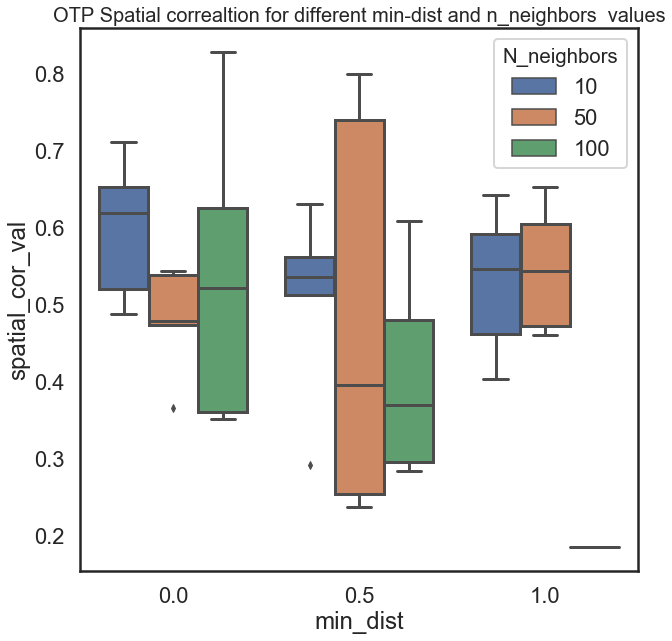

In [187]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="min_dist", y="spatial_cor_val", hue="N_neighbors", data=spatial_cor_umap_md_nn_otp)
plt.title("OTP Spatial correaltion for different min-dist and n_neighbors  values",  fontsize=20)
plt.show()

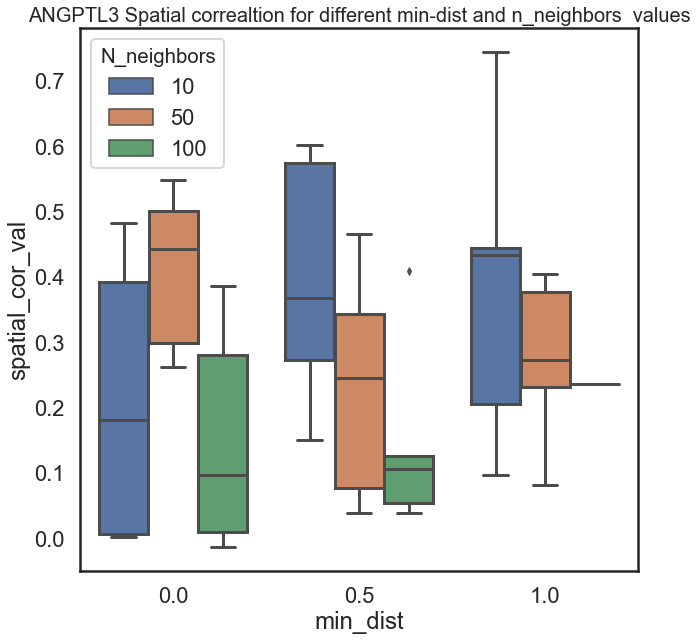

In [188]:
spatial_cor_umap_md_nn_angptl3 = spatial_cor_umap_md.loc[spatial_cor_umap_md['list_spatial_cor'] =="angptl3"]
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.set_context("poster", font_scale = 1)
sns.boxplot(x="min_dist", y="spatial_cor_val", hue="N_neighbors", data=spatial_cor_umap_md_nn_angptl3)
plt.title("ANGPTL3 Spatial correaltion for different min-dist and n_neighbors  values",  fontsize=20)
plt.show()


### Pulmonary carcinoids 5 classes

### Data import

In [201]:
data_lv_50_type5 =  pd.read_csv("t_data_vst_50_type_5class.tsv", sep="\t")
data_lv_50_type5.shape
lv_50_type5_data = data_lv_50_type5.iloc[:,0:6398]
lv_50_type5_type = data_lv_50_type5.iloc[:,6399]
coords_mofa_type5 = pd.read_csv("Mofa_expr_coords_5_classes.tsv", sep="\t")
ml_pred_type5  = pd.read_csv("ML_pred_fig1_5class_df.tsv", sep="\t")
Sample_ID_df_type5 =pd.DataFrame(data_lv_50_type5["Sample_ID"] )

coords_mofa_type5_v2 = pd.merge(coords_mofa_type5, Sample_ID_df_type5, on='Sample_ID', how='inner')
coords_mofa_type5 = coords_mofa_type5_v2

spatial_attributes_type5 = pd.read_csv("Spatial_analysis_attribute_5_classes.tsv", sep="\t")
spatial_attributes_type5.head()

,OTP,ANGPTL3,Dendritic_cell
0,4.892365,12.661357,0.000000
1,13.981876,10.949075,0.008448
2,14.250489,8.717908,0.017431
3,3.756095,3.449389,0.000000
4,12.801411,7.281603,0.006153


In [205]:
lv_50_type5_type

0             Atypical
1             Atypical
2             Atypical
3      Supra_carcinoid
4             Atypical
5             Atypical
6             Atypical
7             Atypical
8             Atypical
9             Atypical
10     Supra_carcinoid
11            Atypical
12            Atypical
13            Atypical
14            Atypical
15            Atypical
16            Atypical
17            Atypical
18            Atypical
19             Typical
20           Carcinoid
21             Typical
22             Typical
23             Typical
24             Typical
25               LCNEC
26               LCNEC
27             Typical
28             Typical
29               LCNEC
            ...       
128              LCNEC
129          Carcinoid
130          Carcinoid
131           Atypical
132              LCNEC
133              LCNEC
134              LCNEC
135              LCNEC
136              LCNEC
137              LCNEC
138              LCNEC
139              LCNEC
140        

#### PCA

In [206]:
palette ={"Typical":"C0","LCNEC":"C1","Atypical":"C2", "diffuse_NOS":"C4", "Supra_carcinoid": "C5"}
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(coords_mofa_type5.iloc[:, 1], coords_mofa_type5[:, 2],  hue=lv_50_type5_type ,s=400, palette=palette)
plt.title("Training data set on PCA coords",  fontsize=20)
plt.show()

TypeError: '(slice(None, None, None), 2)' is an invalid key

# Mesomics 

## Import data

In [95]:
meso_data_type =  pd.read_csv("Meso_data_lv_sample_type.tsv", sep="\t")
meso_data_type.head()
meso_data_type.shape
meso_pca_coords =  pd.read_csv("PCA_coords_MESO.tsv", sep="\t")
palette ={"Biphasic":"darkorange","Diffuse_NOS":"black","Epithelioid":"mediumseagreen", "Sarcomatoid":"tomato"}

In [96]:
data_expr_meso = meso_data_type.iloc[:,1:7145]
data_type_meso = meso_data_type.iloc[:,7146]

## Supervised Unsupervised

In [97]:
typeN_meso  = []
for i in range(len(data_type_meso)):
    if data_type_meso[i]== 'Biphasic':
        typeN_meso.append(1)
    elif data_type_meso[i]== 'Diffuse_NOS':
        typeN_meso.append(2)
    elif data_type_meso[i]== 'Epithelioid':
        typeN_meso.append(3)
    elif data_type_meso[i]== 'Sarcomatoid':  
        typeN_meso.append(4)
    else :
        print("WARNING i = ", i)
        break
palette_N ={1:"darkorange",2:"black",3:"mediumseagreen", 4:"tomato"}

### Unsupervised

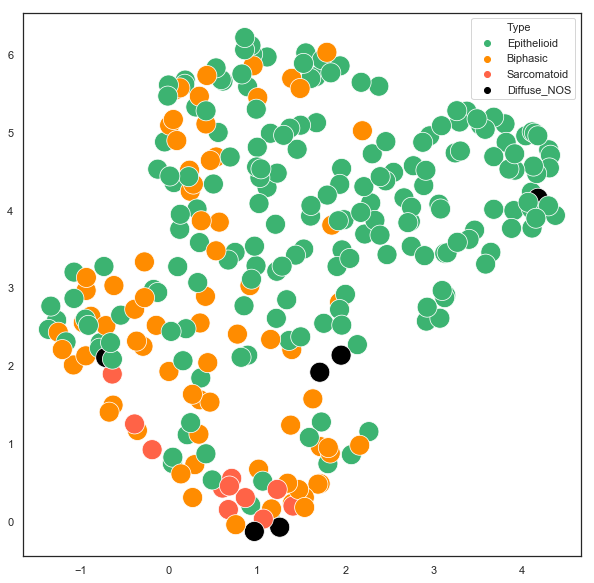

In [98]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
standard_embedding_meso = umap.UMAP().fit_transform(data_expr_meso )
sns.scatterplot(x=standard_embedding_meso[:, 0], y=standard_embedding_meso[:, 1], s=400, hue=data_type_meso, palette=palette)
plt.show()

### Supervised

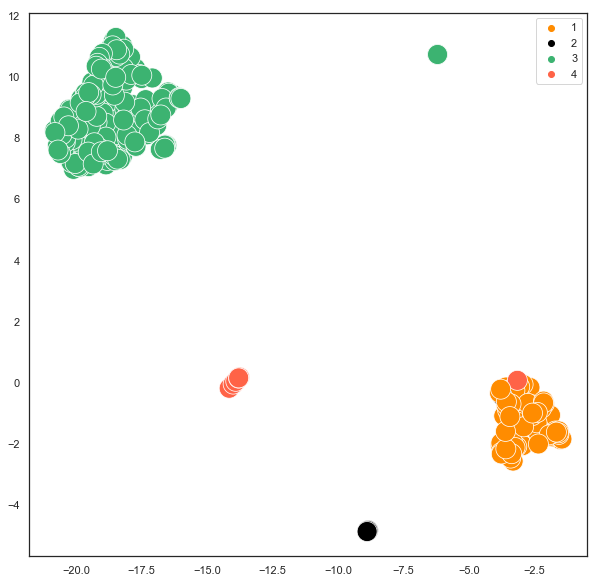

In [99]:
embedding = umap.UMAP().fit_transform(data_expr_meso , y=typeN_meso )
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=400, hue=typeN_meso , palette =palette_N)
plt.show()

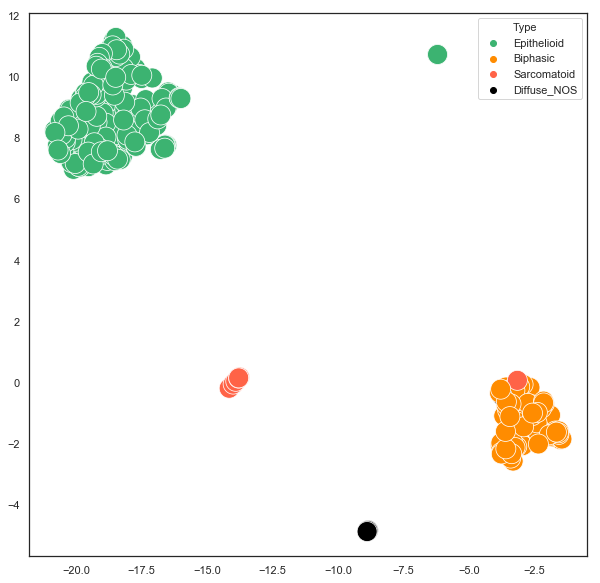

In [100]:
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=400, hue=data_type_meso , palette =palette)
plt.show()

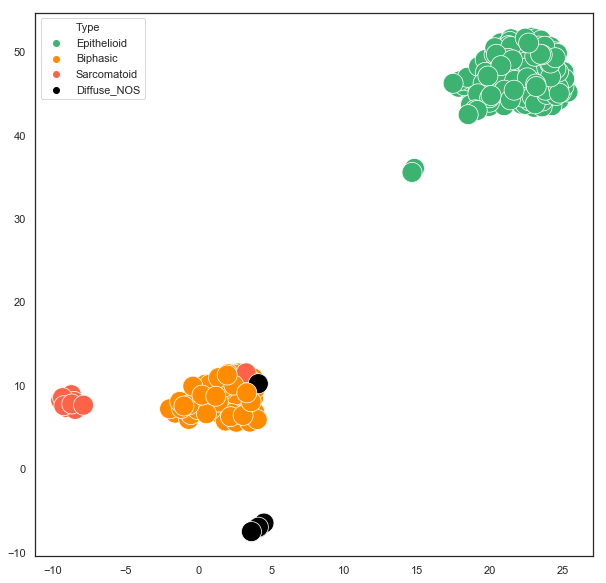

In [101]:
embedding = umap.UMAP( min_dist = 0.99).fit_transform(data_expr_meso , y=typeN_meso)
sns.set(style='white', rc={'figure.figsize':(10,10)})
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=400, hue=data_type_meso , palette =palette)
plt.show()

### Spatial correlation 
#### Import features

In [102]:
Meso_spatial_cor_data =  pd.read_csv("Meso_spatial_cor_att.tsv", sep="\t")

In [103]:
CV = train_test_split(data_expr_meso ,data_type_meso, data_type_meso )
X_train = CV[0]
X_test = CV[1]
y_train = CV[2]
y_test = CV[3]

In [104]:
kmeans = KMeans(n_clusters=4).fit(X_train)
pred_kmeans = kmeans.predict(X_test)
kmean_acc , kmean_lab =label_pred(y_test, pred_kmeans)

pred_label    0   1   2  3
y_test                    
Biphasic      6   1  10  5
Diffuse_NOS   0   0   1  1
Epithelioid  25  15   4  1
Sarcomatoid   0   0   0  2
acc_score [0.16901408450704225, 0.09859154929577464, 0.3380281690140845, 0.11267605633802817, 0.30985915492957744, 0.15492957746478872, 0.09859154929577464, 0.028169014084507043, 0.4084507042253521, 0.04225352112676056, 0.38028169014084506, 0.08450704225352113, 0.38028169014084506, 0.15492957746478872, 0.5211267605633803, 0.15492957746478872, 0.5070422535211268, 0.36619718309859156, 0.28169014084507044, 0.1267605633802817, 0.4225352112676056, 0.1267605633802817, 0.43661971830985913, 0.29577464788732394]
c_dict {2: 'Biphasic', 1: 'Diffuse_NOS', 0: 'Epithelioid', 3: 'Sarcomatoid'}


In [92]:
min_dist_test = [0,0.5,1]
nn_test = [10,50,100]


knn_acc = []
kmeans_acc = []
svc_acc = []

knn_silh = []
kmeans_silh = []
svc_silh = []

min_dist = []
N_neighbors =[]

vista_spatial_cor =[]
pdl1_spatial_cord =[]
survival_spatial_cor= []

for i in min_dist_test :
    for j in nn_test:
        print('\n')
        print('i', i)
        for z  in range(10):
            CV = train_test_split(data_expr_meso ,data_type_meso,data_type_meso )
            X_train = CV[0]
            X_test = CV[1]
            y_train = CV[2]
            y_test = CV[3]
        
            trans = umap.UMAP(min_dist = i, n_neighbors = j ).fit(X_train)
            svc_2 = SVC().fit(trans.embedding_, y_train)
            knn_2 = KNeighborsClassifier().fit(trans.embedding_, y_train)
            kmeans_2 = KMeans(n_clusters=4).fit(trans.embedding_, y_train)
        
            test_embedding = trans.transform(X_test)
            svc_pred_2= svc_2.predict(test_embedding)
            knn_pred_2 = knn_2.predict(test_embedding)
            kmeans_pred_2 = kmeans_2.predict(test_embedding)
        
            kmean_acc_2 , kmean_lab_2 =label_pred(y_test, kmeans_pred_2 )
        
            print("Knn accurancy  : ",knn_2.score(trans.transform(X_test), y_test) )
            print("SVC accurancy  : ",svc_2.score(trans.transform(X_test), y_test) )
            print("Kmeans accurancy  : ",kmean_acc_2 )
        
            print("Knn silhouette score  : ",silhouette_score(trans.transform(X_test), knn_pred_2) )
            print("Svc silhouette score  : ",silhouette_score(trans.transform(X_test), svc_pred_2) )
            print("Kmeans silhouette score  : ",silhouette_score(trans.transform(X_test), kmeans_pred_2) )
        
            min_dist.append(i)
            N_neighbors.append(j)
            knn_acc.append(knn_2.score(trans.transform(X_test), y_test))
            svc_acc.append(svc_2.score(trans.transform(X_test), y_test))
            kmeans_acc.append(kmean_acc_2)
        
            knn_silh.append(silhouette_score(trans.transform(X_test), knn_pred_2))
            svc_silh.append(silhouette_score(trans.transform(X_test), svc_pred_2))
            kmeans_silh.append(silhouette_score(trans.transform(X_test), kmeans_pred_2))
       
            wknn10 = pysal.knnW(test_embedding, k = 10)
    
            vista_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,0])
            ANGPTL3_gene_expression = np.array(spatial_attributes.iloc[X_test.index.values,1])
            dendritic_cell = np.array(spatial_attributes.iloc[X_test.index.values,2])
    
            mi_otp = pysal.Moran(OTP_gene_expression, wknn10 , two_tailed=True)
            otp_spatial_cor_umap_md.append(mi_otp.I)


            mi_angptl3 = pysal.Moran(ANGPTL3_gene_expression, wknn10 , two_tailed=True)
            angptl3_spatial_cor_umap_md.append(mi_angptl3.I)
 

            mi_dendritic_cell = pysal.Moran(dendritic_cell, wknn10 , two_tailed=True)
            dendritic_cells_spatial_cor_umap_md.append(mi_dendritic_cell.I)
    
        



i 0


NameError: name 'data_expr_meso' is not defined